# Compare vaccination strategies per ERVA and age groups. $e$=0.95

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']
len_bar = 5
color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sep_bet_group = 3*len_bar
legend_width = 4

begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
ts = [begin + datetime.timedelta(days=day) for day in range(T)]
print('Simulation ends: %s' % (ts[-1]))
t2 = int(T-1)
t1_time = datetime.datetime(year=2021, month=7, day=1)
t1 = ts.index(t1_time)
e = 0.95

strategies = [
    ('equal', EPIDEMIC['ws_vacc'], 'Pop only'),
    ('no_vacc', EPIDEMIC['ws_vacc'], 'No vaccination'),
    ('thl', EPIDEMIC['ws_vacc'], 'Pop, Inf and Hosp'),
    ('thl', [1/2, 1/2, 0], 'Pop and Hosp'),
    ('thl', [1/2, 0, 1/2], 'Pop and Inf'),
    ('thl', [0, 1/2, 1/2], 'Hosp and Inf'),
    ('thl', [0, 1, 0], 'Hosp only'),
    ('thl', [0, 0, 1], 'Inf only'),
]

Simulation ends: 2021-08-10 00:00:00


In [3]:
all_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=True,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0,
                                      e=e)

Beginning experiments.
Parameters:
Number of age ervas: 5.
Number of age groups: 9.
Number of vaccines per day: 30000.
rho: 42.30095393674314.
t0: 2021-04-18.
T: 115.
Vaccine efficacy (e): 0.95.
Rs to try: [1.0, 1.25, 1.5, 2.0].
Initialize with vaccinated people: True.
Strategies:
[('equal', [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'Pop only'), ('no_vacc', [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'No vaccination'), ('thl', [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'Pop, Inf and Hosp'), ('thl', [0.5, 0.5, 0], 'Pop and Hosp'), ('thl', [0.5, 0, 0.5], 'Pop and Inf'), ('thl', [0, 0.5, 0.5], 'Hosp and Inf'), ('thl', [0, 1, 0], 'Hosp only'), ('thl', [0, 0, 1], 'Inf only')].

Finished R: 1.0. Beta: 0.023640128813534566 1/4. Policy: Pop only. 1/8
Finished R: 1.0. Beta: 0.023640128813534566 1/4. Policy: No vaccination. 2/8
Finished R: 1.0. Beta: 0.023640128813534566 1/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.0. Beta: 0.02364012

In [4]:
def plot_bars_ages_ervas(ax, r, metric, all_results, labels, plot, t2=t2, t1=t1):
    results_for_r = all_results[r]
    
    total_strategies = len(results_for_r)
    space_label = len_bar*(total_strategies-1) + sep_bet_group
    
    no_vacc_results = None
    for label, results_all_metrics in results_for_r:
        if label == 'No vaccination':
            no_vacc_results = results_all_metrics[metric]

            if metric != 'deaths':
                no_vacc_results_cum = no_vacc_results.cumsum(axis=2)
            else:
                no_vacc_results_cum = no_vacc_results

            if plot == 'ERVA':
                no_vacc_results_cum = no_vacc_results_cum.sum(axis=0)
            elif plot == 'Age group':
                no_vacc_results_cum = no_vacc_results_cum.sum(axis=1)
            else:
                raise ValueError('Not valid value to plot')
    
    assert no_vacc_results is not None
    
    total_plot_space = space_label*len(labels) + sep_bet_group
    ax.set_xlim(0, total_plot_space)
    
    num_strategy = 0
    legend_elements = []
    for label, results_all_metrics in results_for_r:
        if label != 'No vaccination':
            policy_results = results_all_metrics[metric]
            
            if metric != 'deaths':
                policy_results_cum = policy_results.cumsum(axis=2)
            else:
                policy_results_cum = policy_results

            if plot == 'ERVA':
                policy_results_cum = policy_results_cum.sum(axis=0)
            elif plot == 'Age group':
                policy_results_cum = policy_results_cum.sum(axis=1)
            else:
                raise ValueError('Not valid value to plot')

                
            assert policy_results_cum.shape == no_vacc_results_cum.shape
            assert no_vacc_results_cum.shape[0] == len(labels)
            
            relative_to_no_vacc = (no_vacc_results_cum - policy_results_cum)/no_vacc_results_cum
            min_red = relative_to_no_vacc[:, t1]*100
            max_red = relative_to_no_vacc[:, t2]*100
            
            
            for label_i in range(len(labels)):
                x1_square = label_i*space_label + sep_bet_group + num_strategy*len_bar
                y1_square = min_red[label_i]
                y2_square = max_red[label_i] - min_red[label_i]

                ax.broken_barh([(x1_square, len_bar), ], (y1_square, y2_square),
                               color=color_palette[num_strategy])
                
            legend_elements.append(Line2D([0], [0], color=color_palette[num_strategy], lw=legend_width, label=label))
            
            num_strategy += 1
    
    space_bars = space_label - sep_bet_group
    middle_of_space = space_bars/2
    pos_tick =  sep_bet_group + middle_of_space
    ticks = []
    for label_i in range(len(labels)):
        abs_pos_tick = label_i*space_label + pos_tick
        ticks.append(abs_pos_tick)
        
    assert len(ticks) == len(labels)
    assert len(legend_elements) == total_strategies-1
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(0, 105, 5))
    ax.set_xlabel(plot)
    ax.set_ylabel('Reduction in percentage')
    ax.set_title('Reduction in %s at %ss per policy . R=%s' % (metric, plot, r))
    ax.legend(handles=legend_elements, loc='upper left', framealpha=0.5)
    

    return ax

# Deaths at ERVAs

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


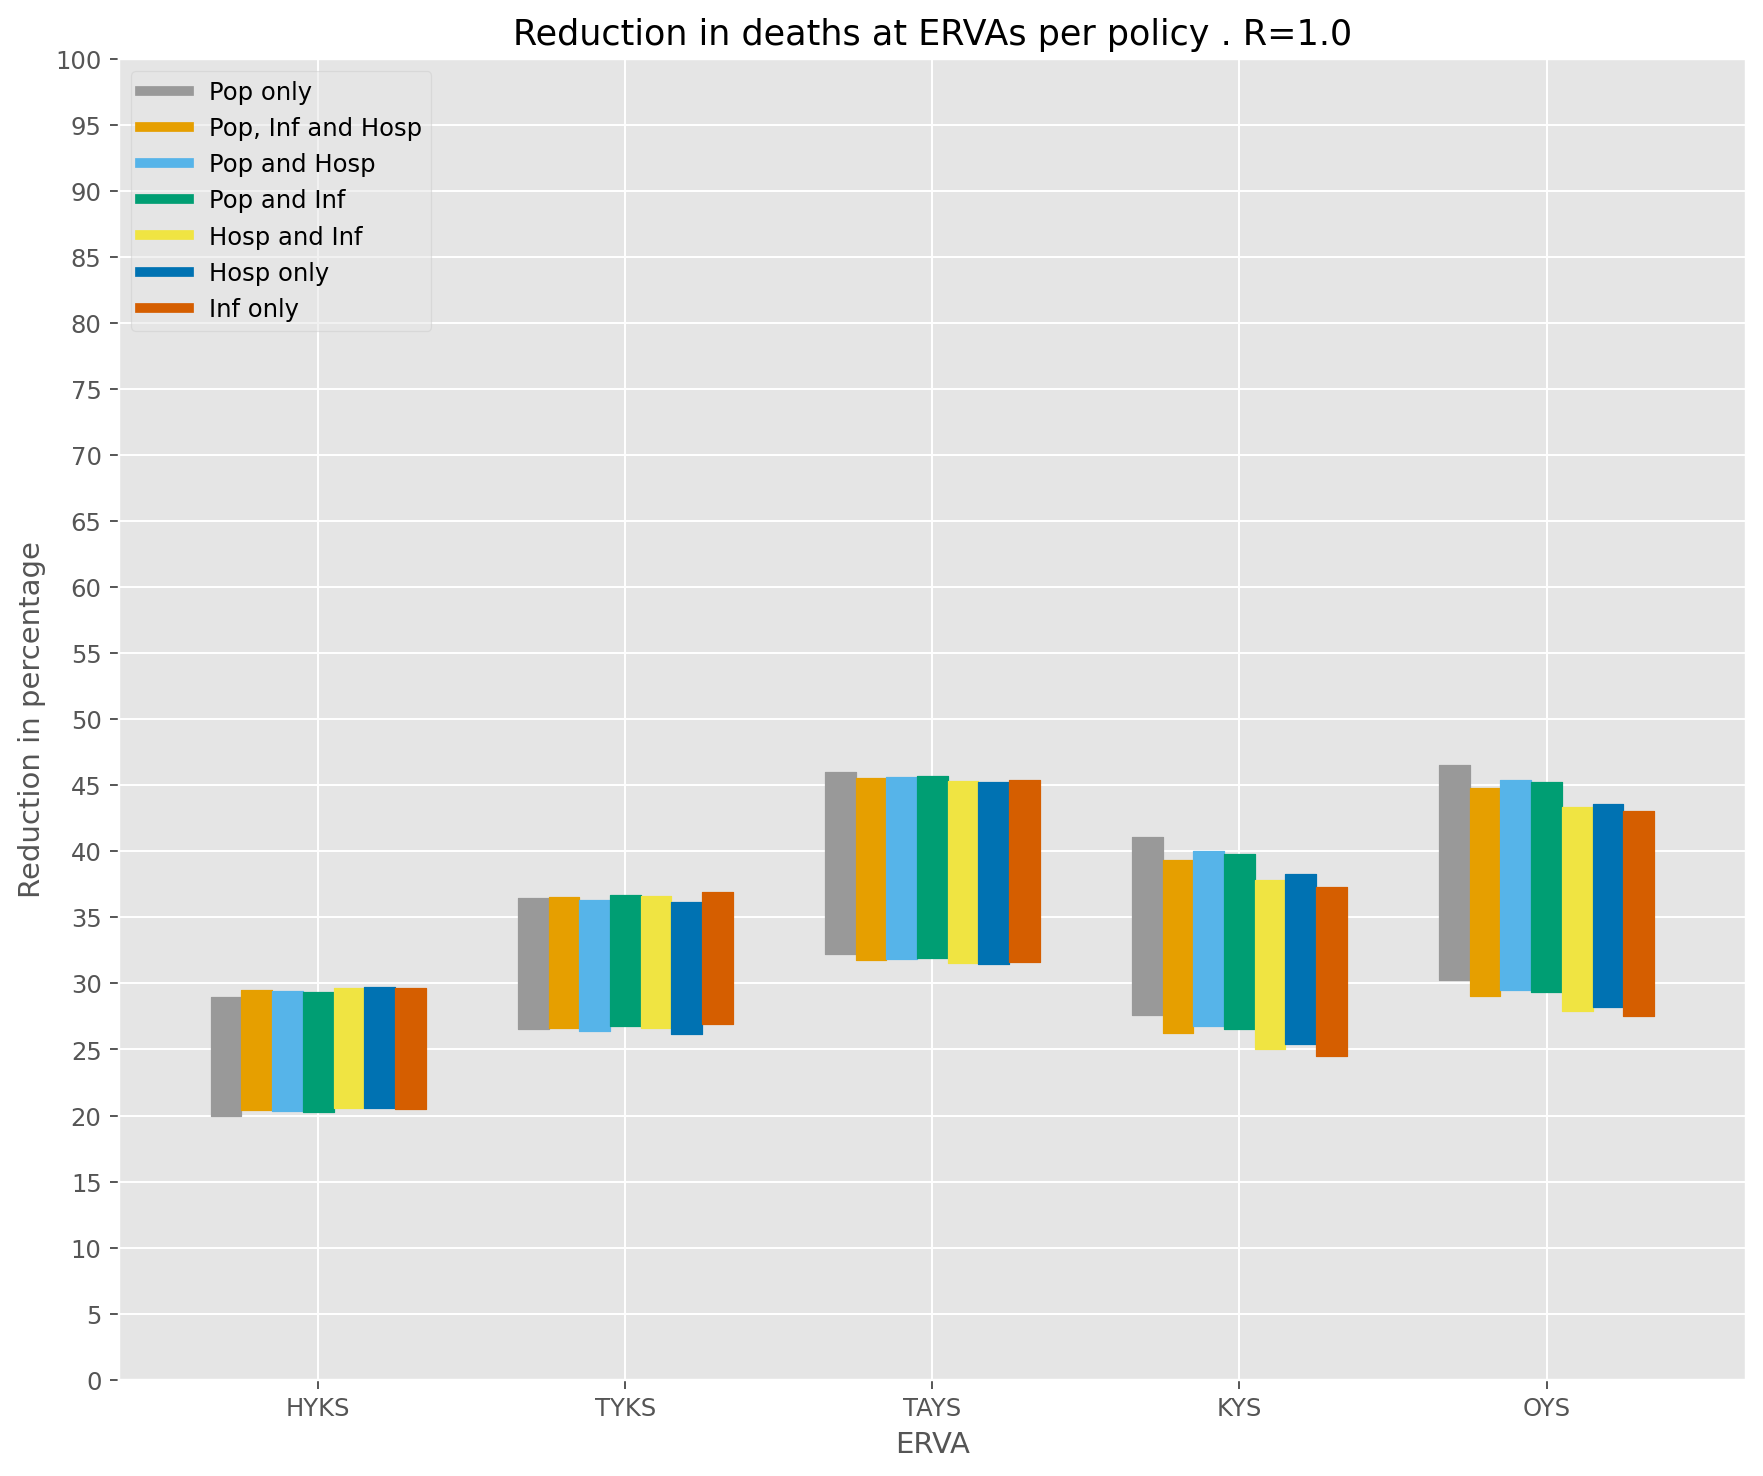

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[0], 'deaths', all_results, ervas_labels, 'ERVA')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


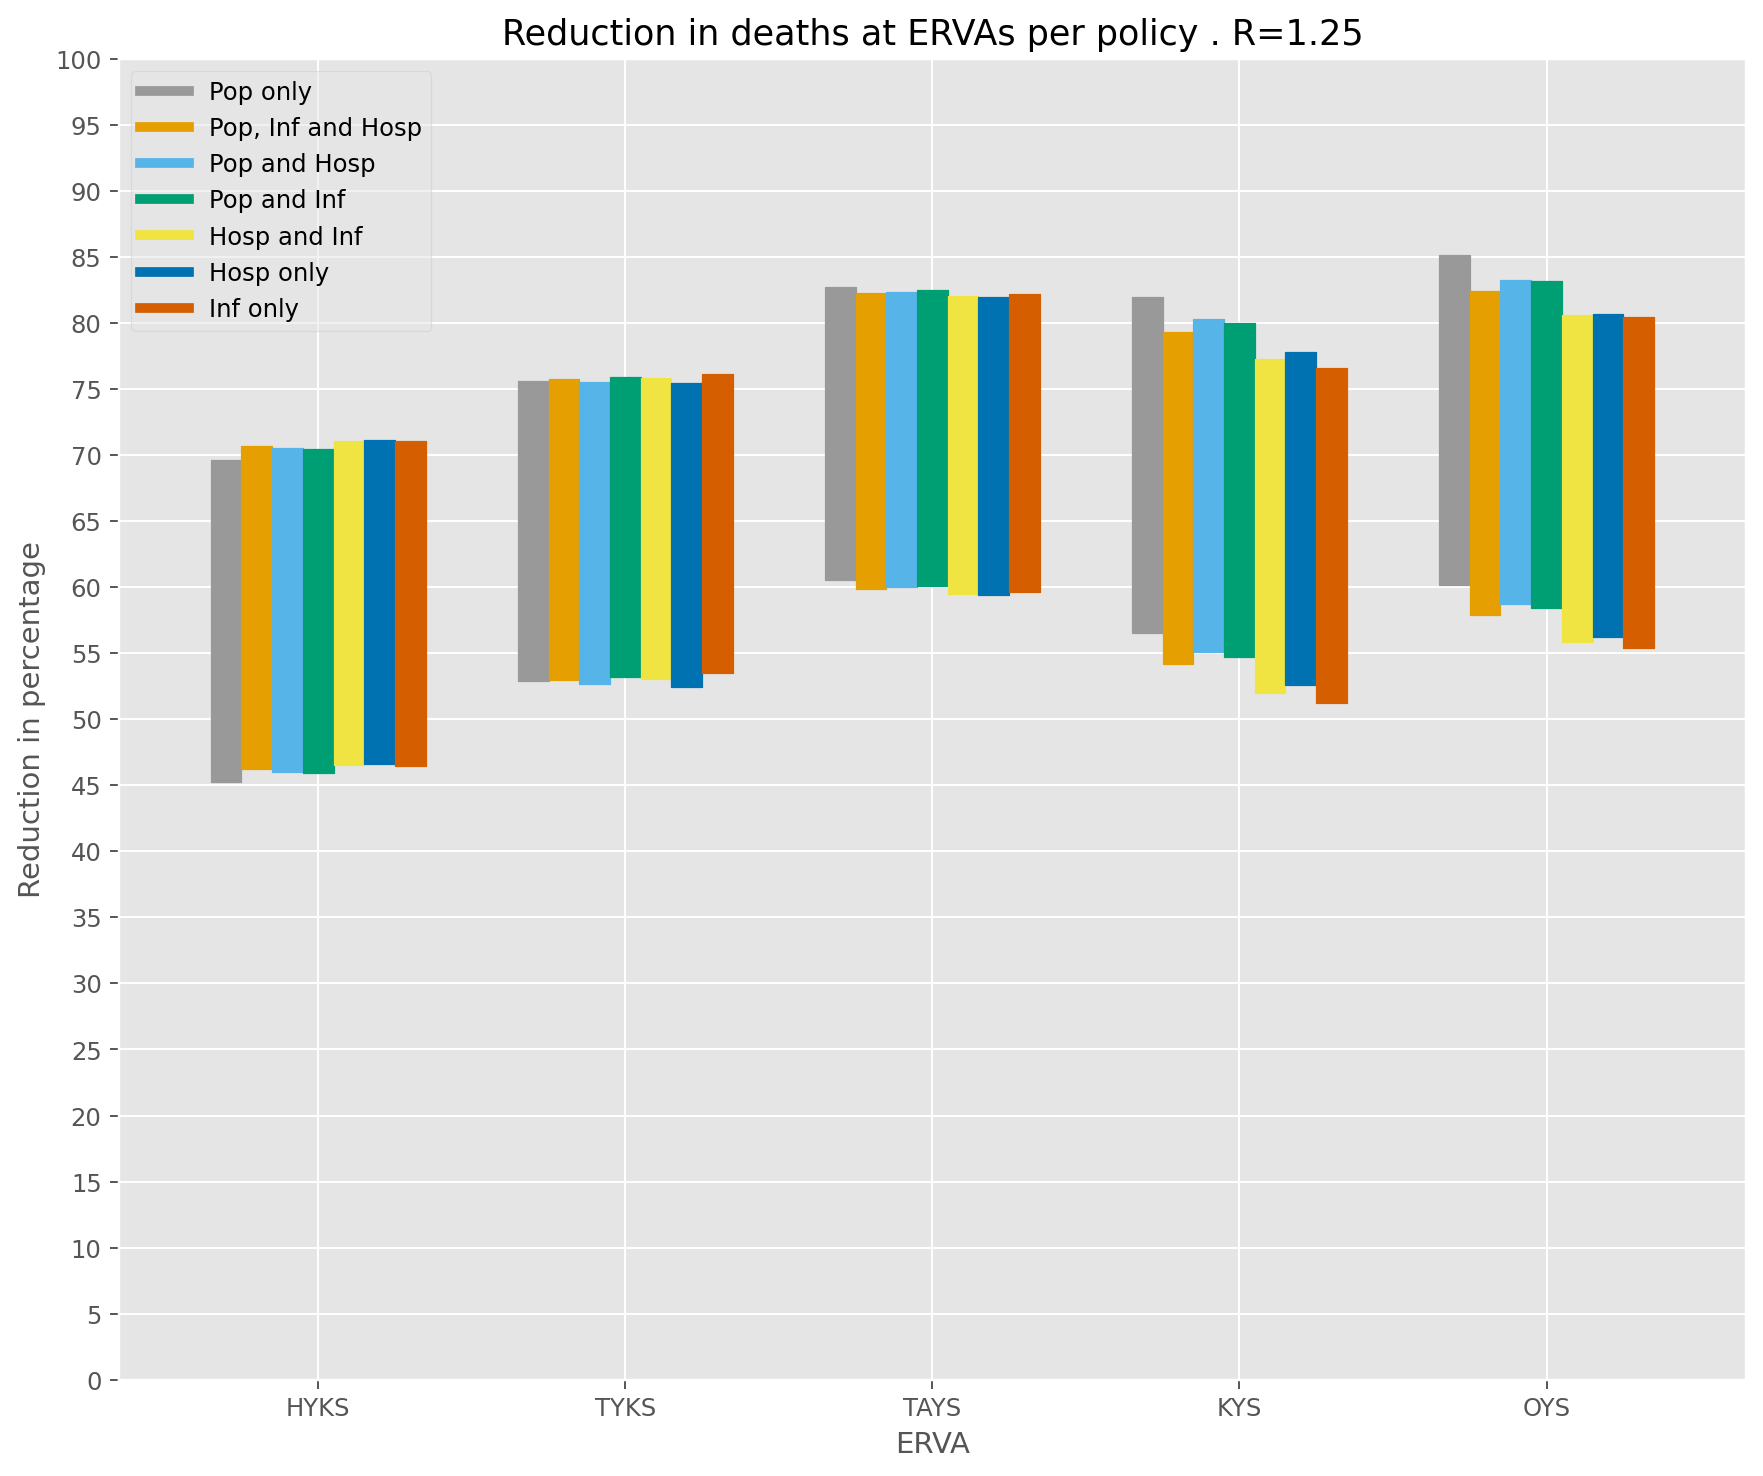

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[1], 'deaths', all_results, ervas_labels, 'ERVA')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


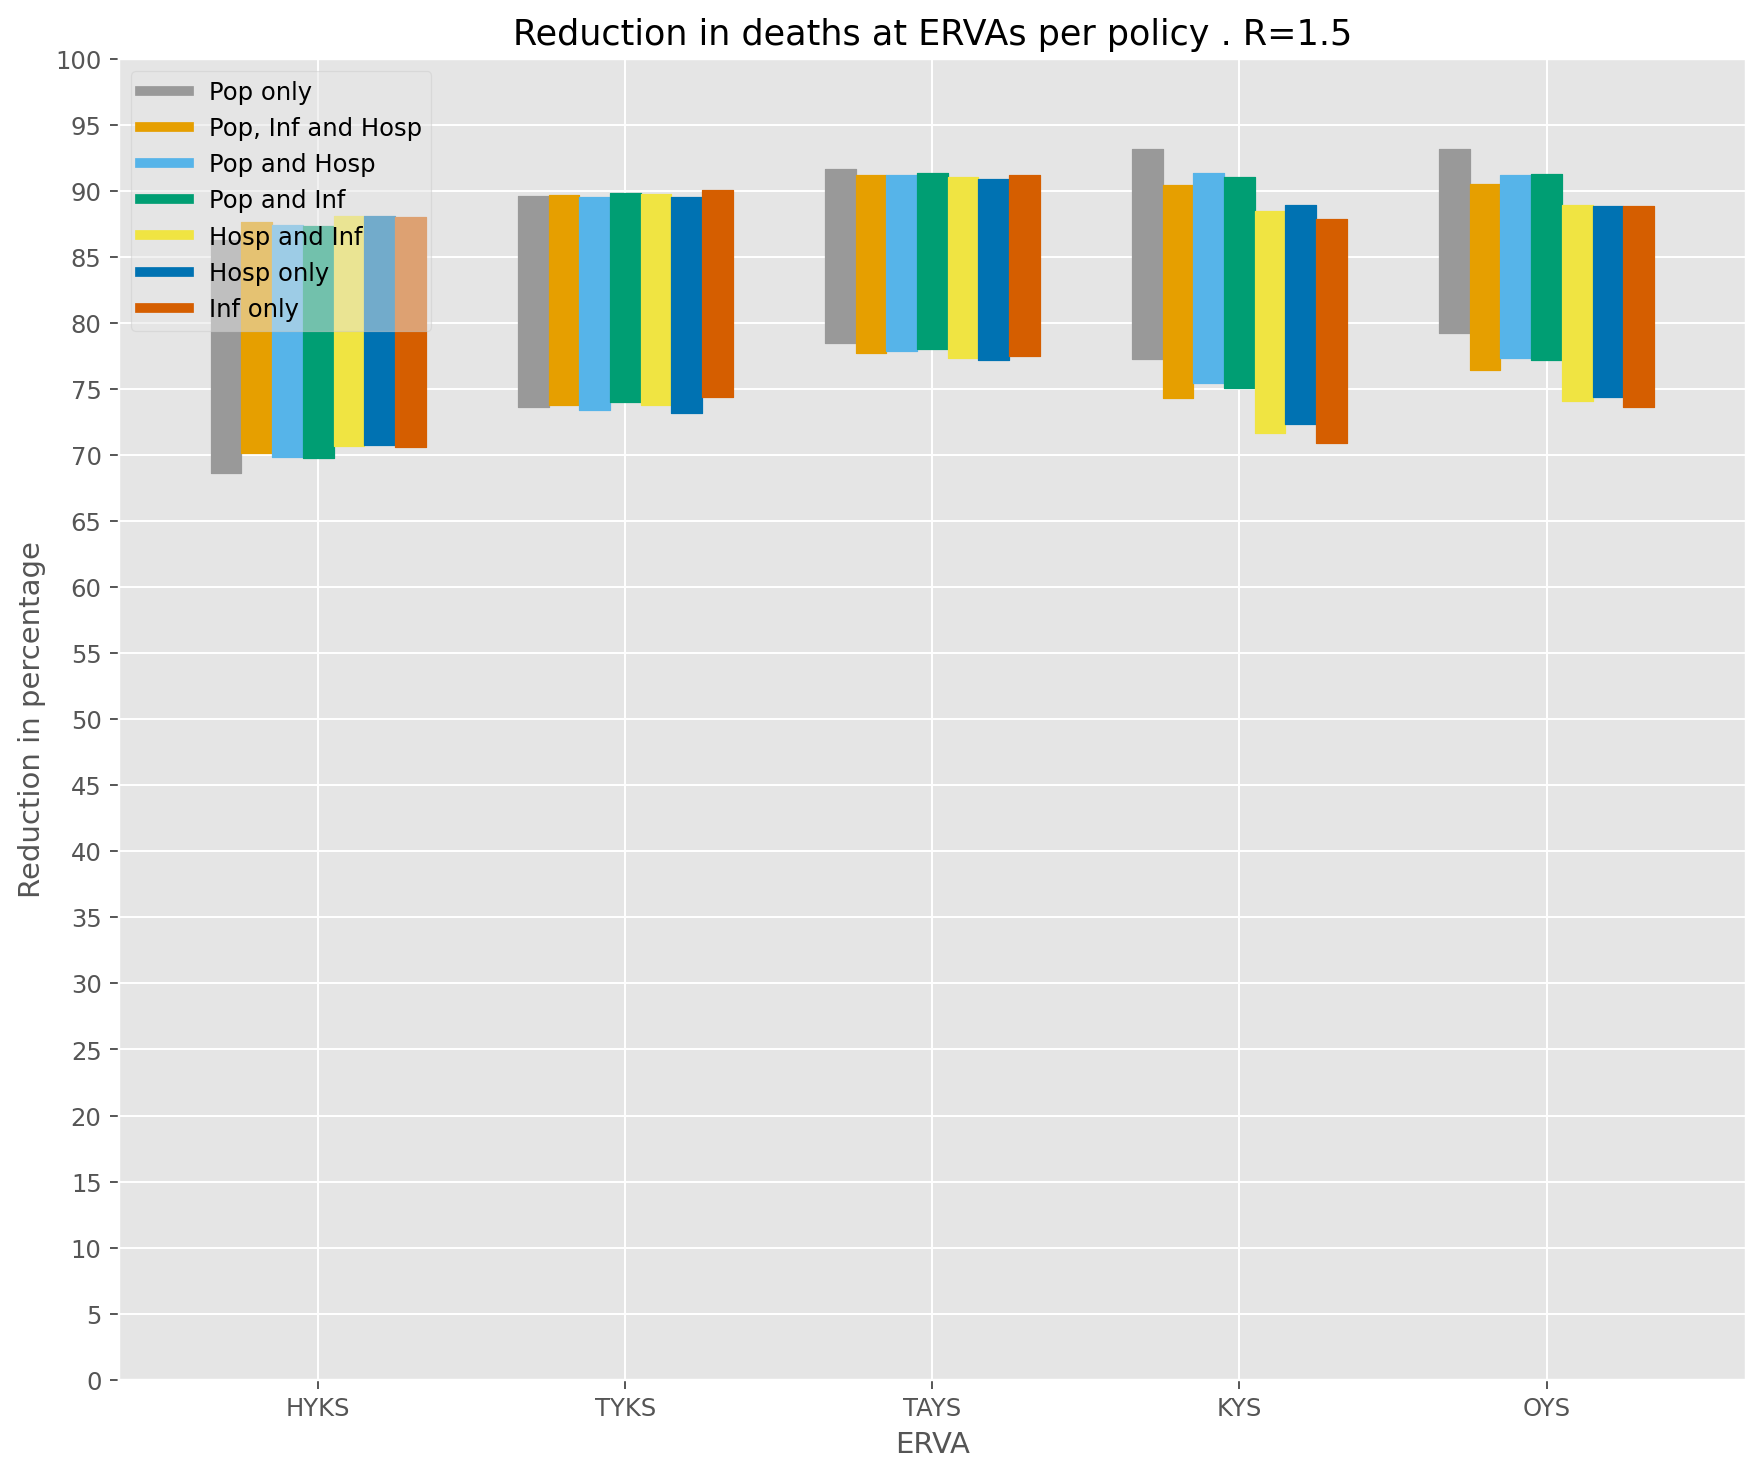

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[2], 'deaths', all_results, ervas_labels, 'ERVA')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


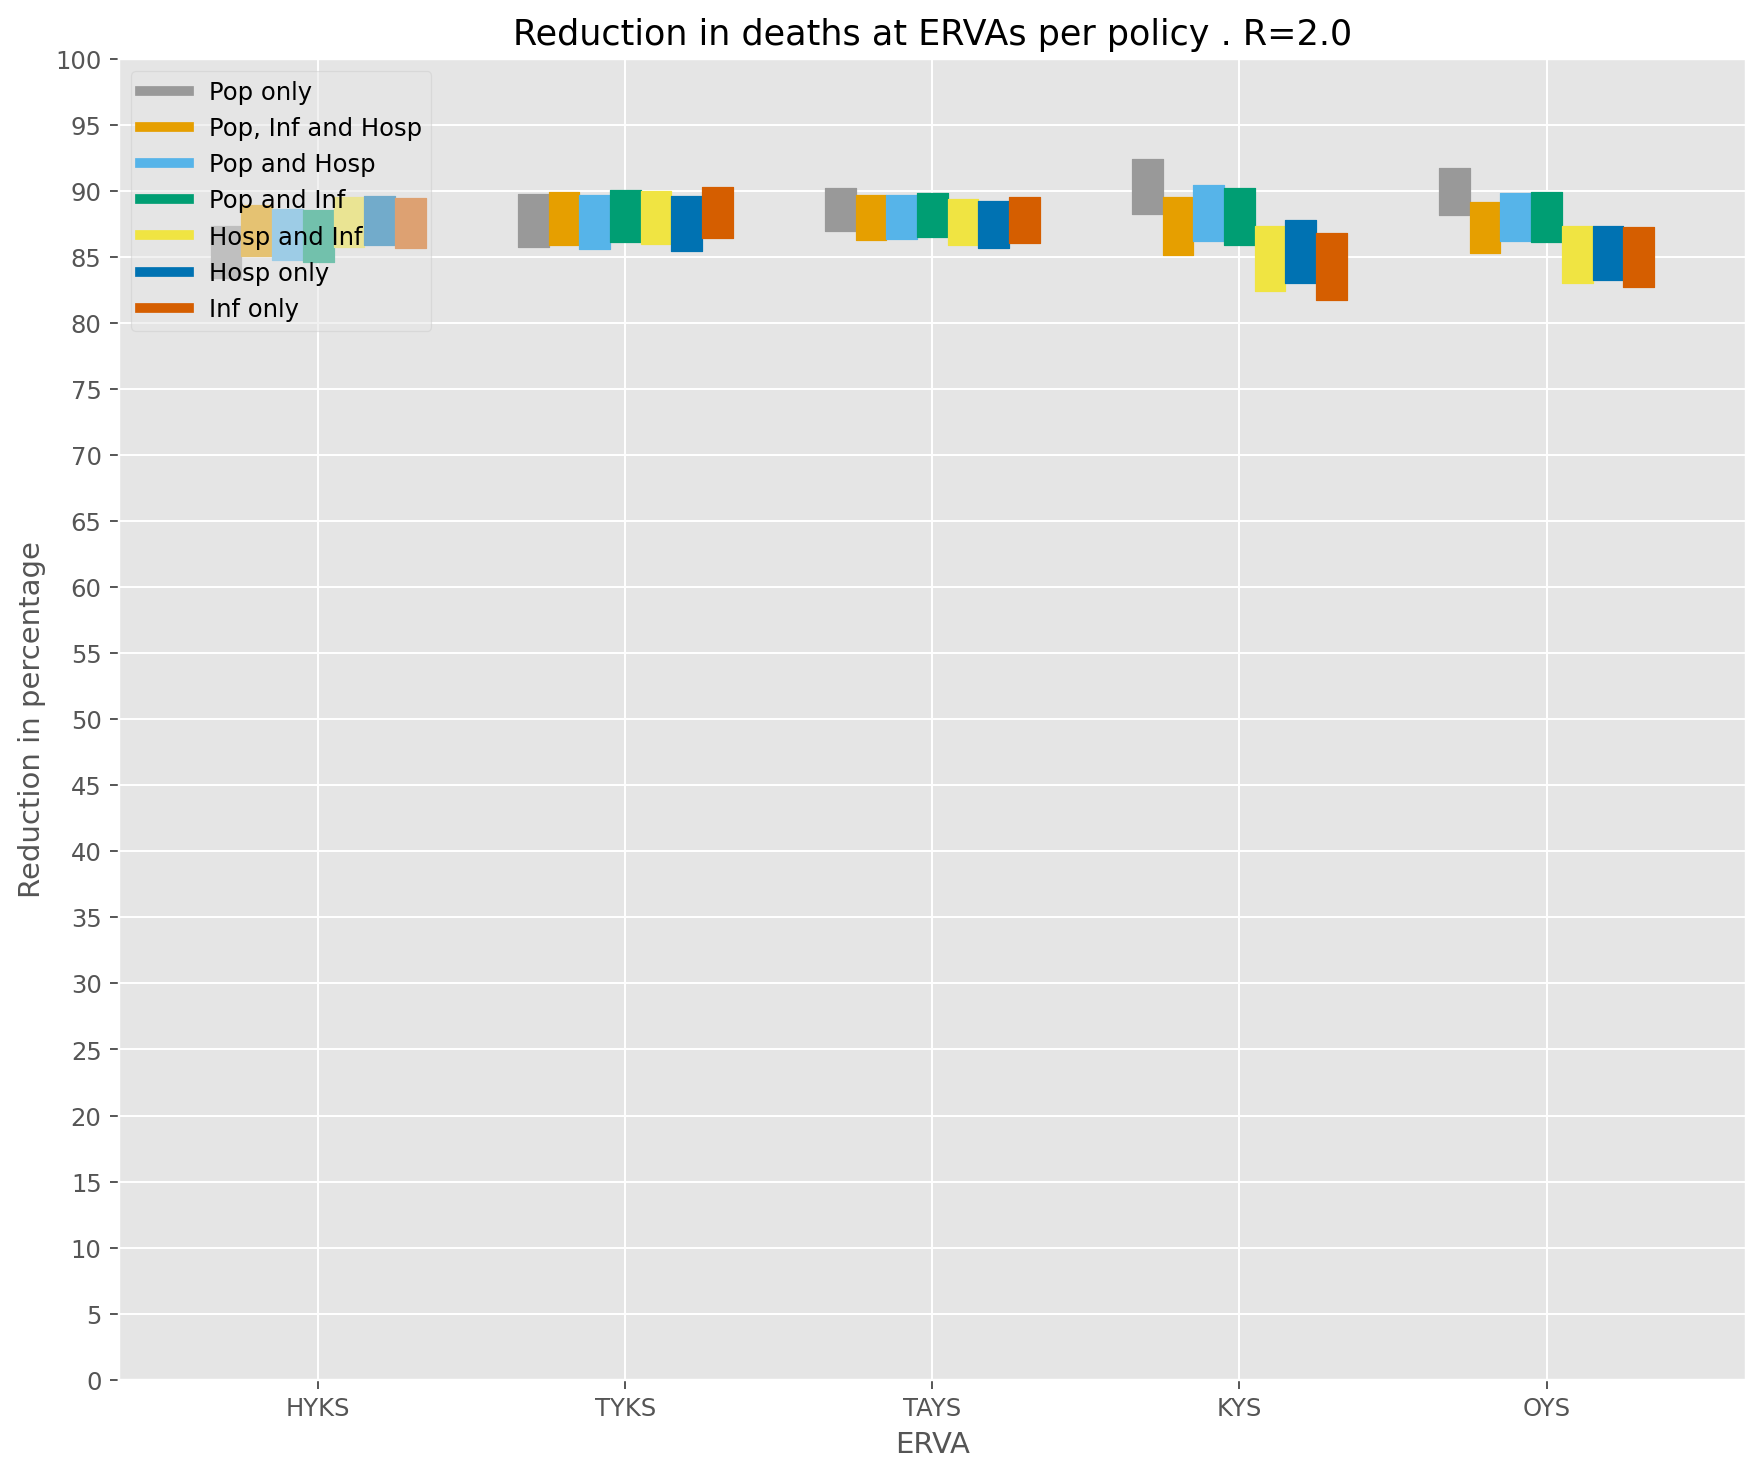

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[3], 'deaths', all_results, ervas_labels, 'ERVA')

# Hospitalizations at ERVAs

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


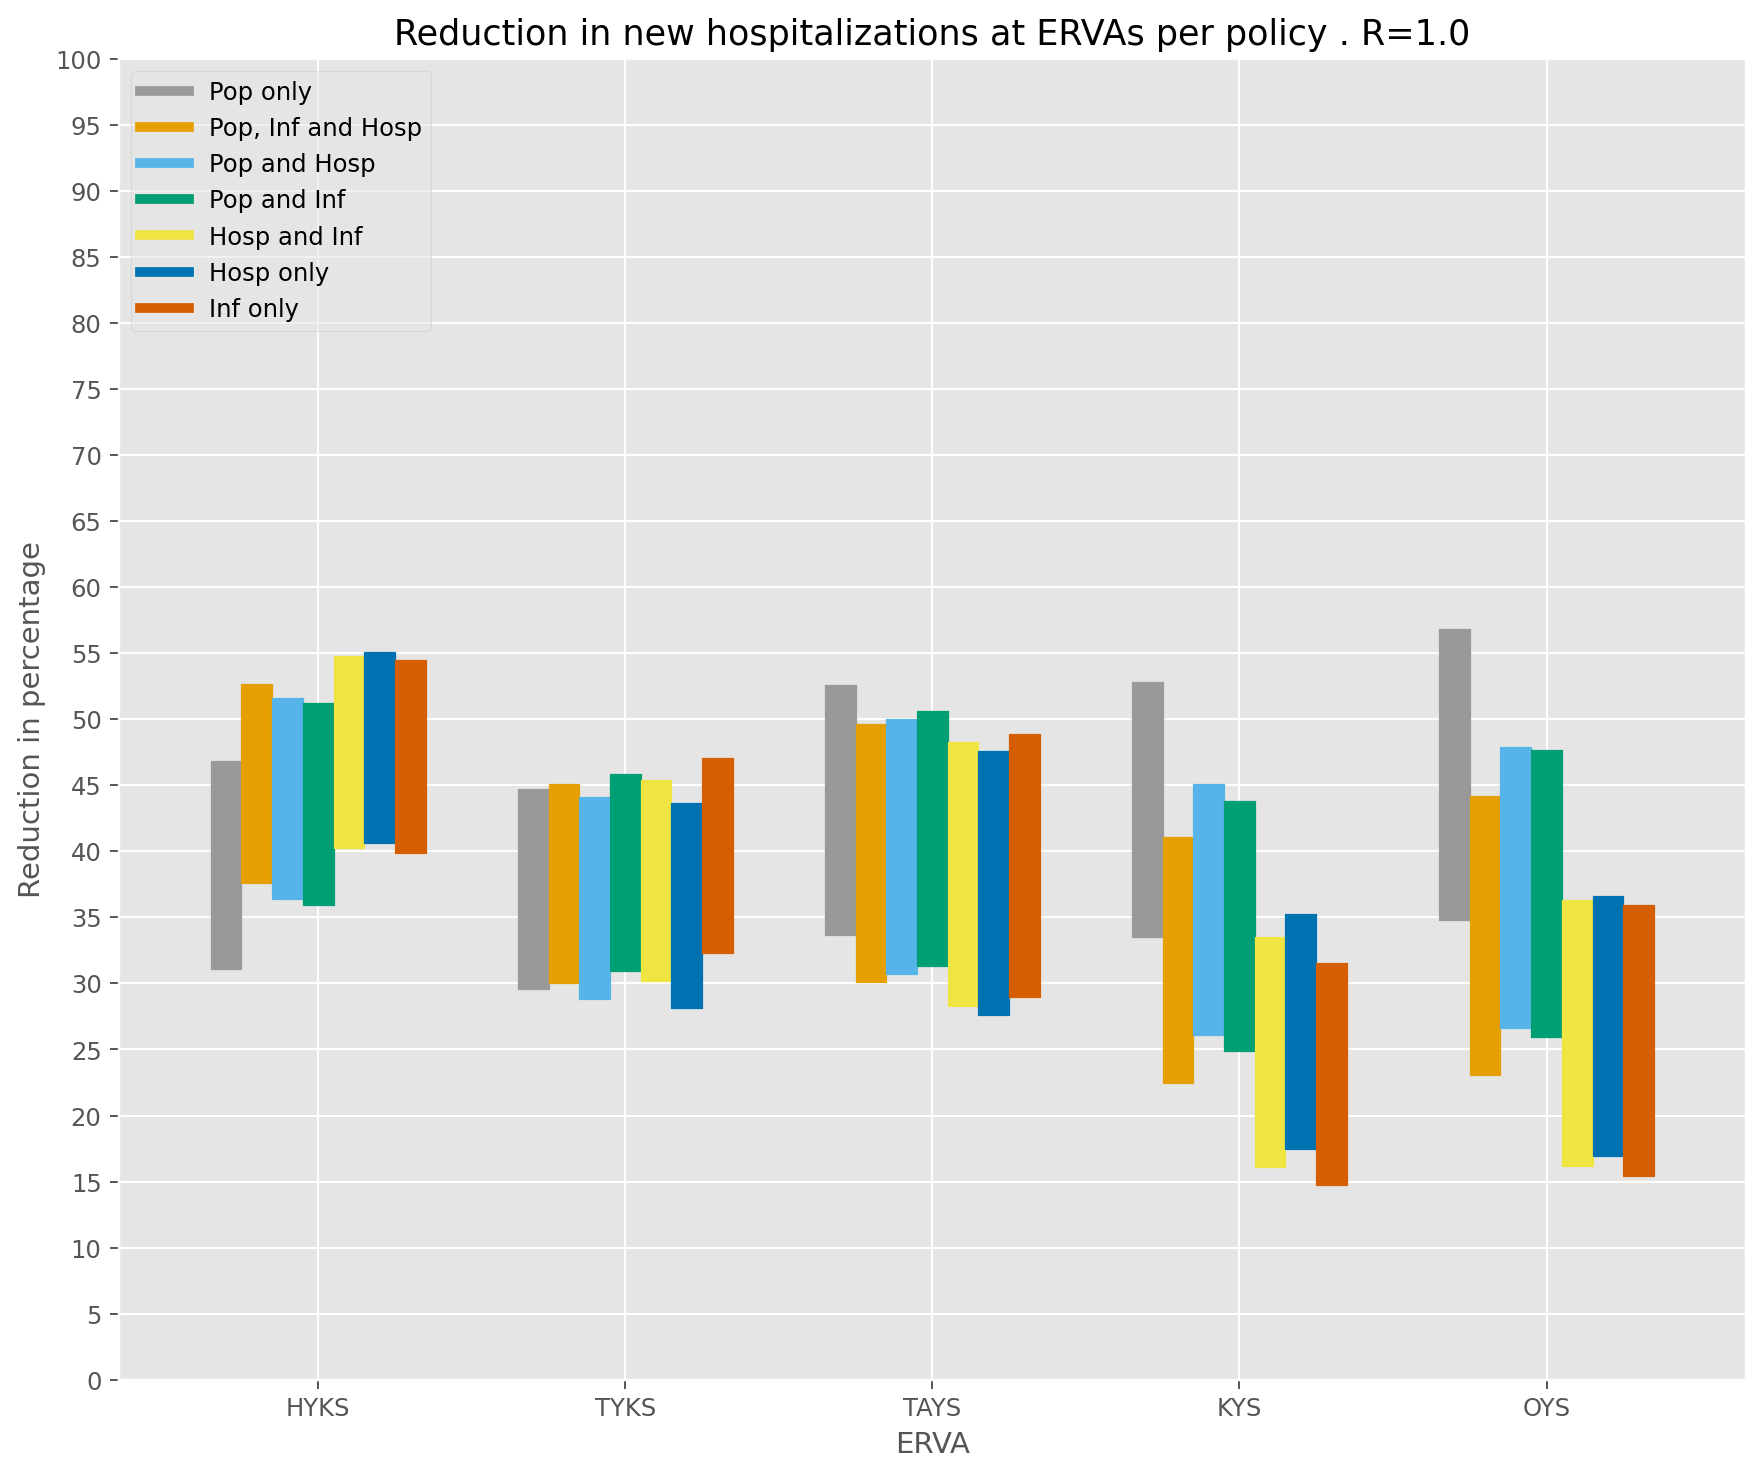

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[0], 'new hospitalizations', all_results, ervas_labels, 'ERVA')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


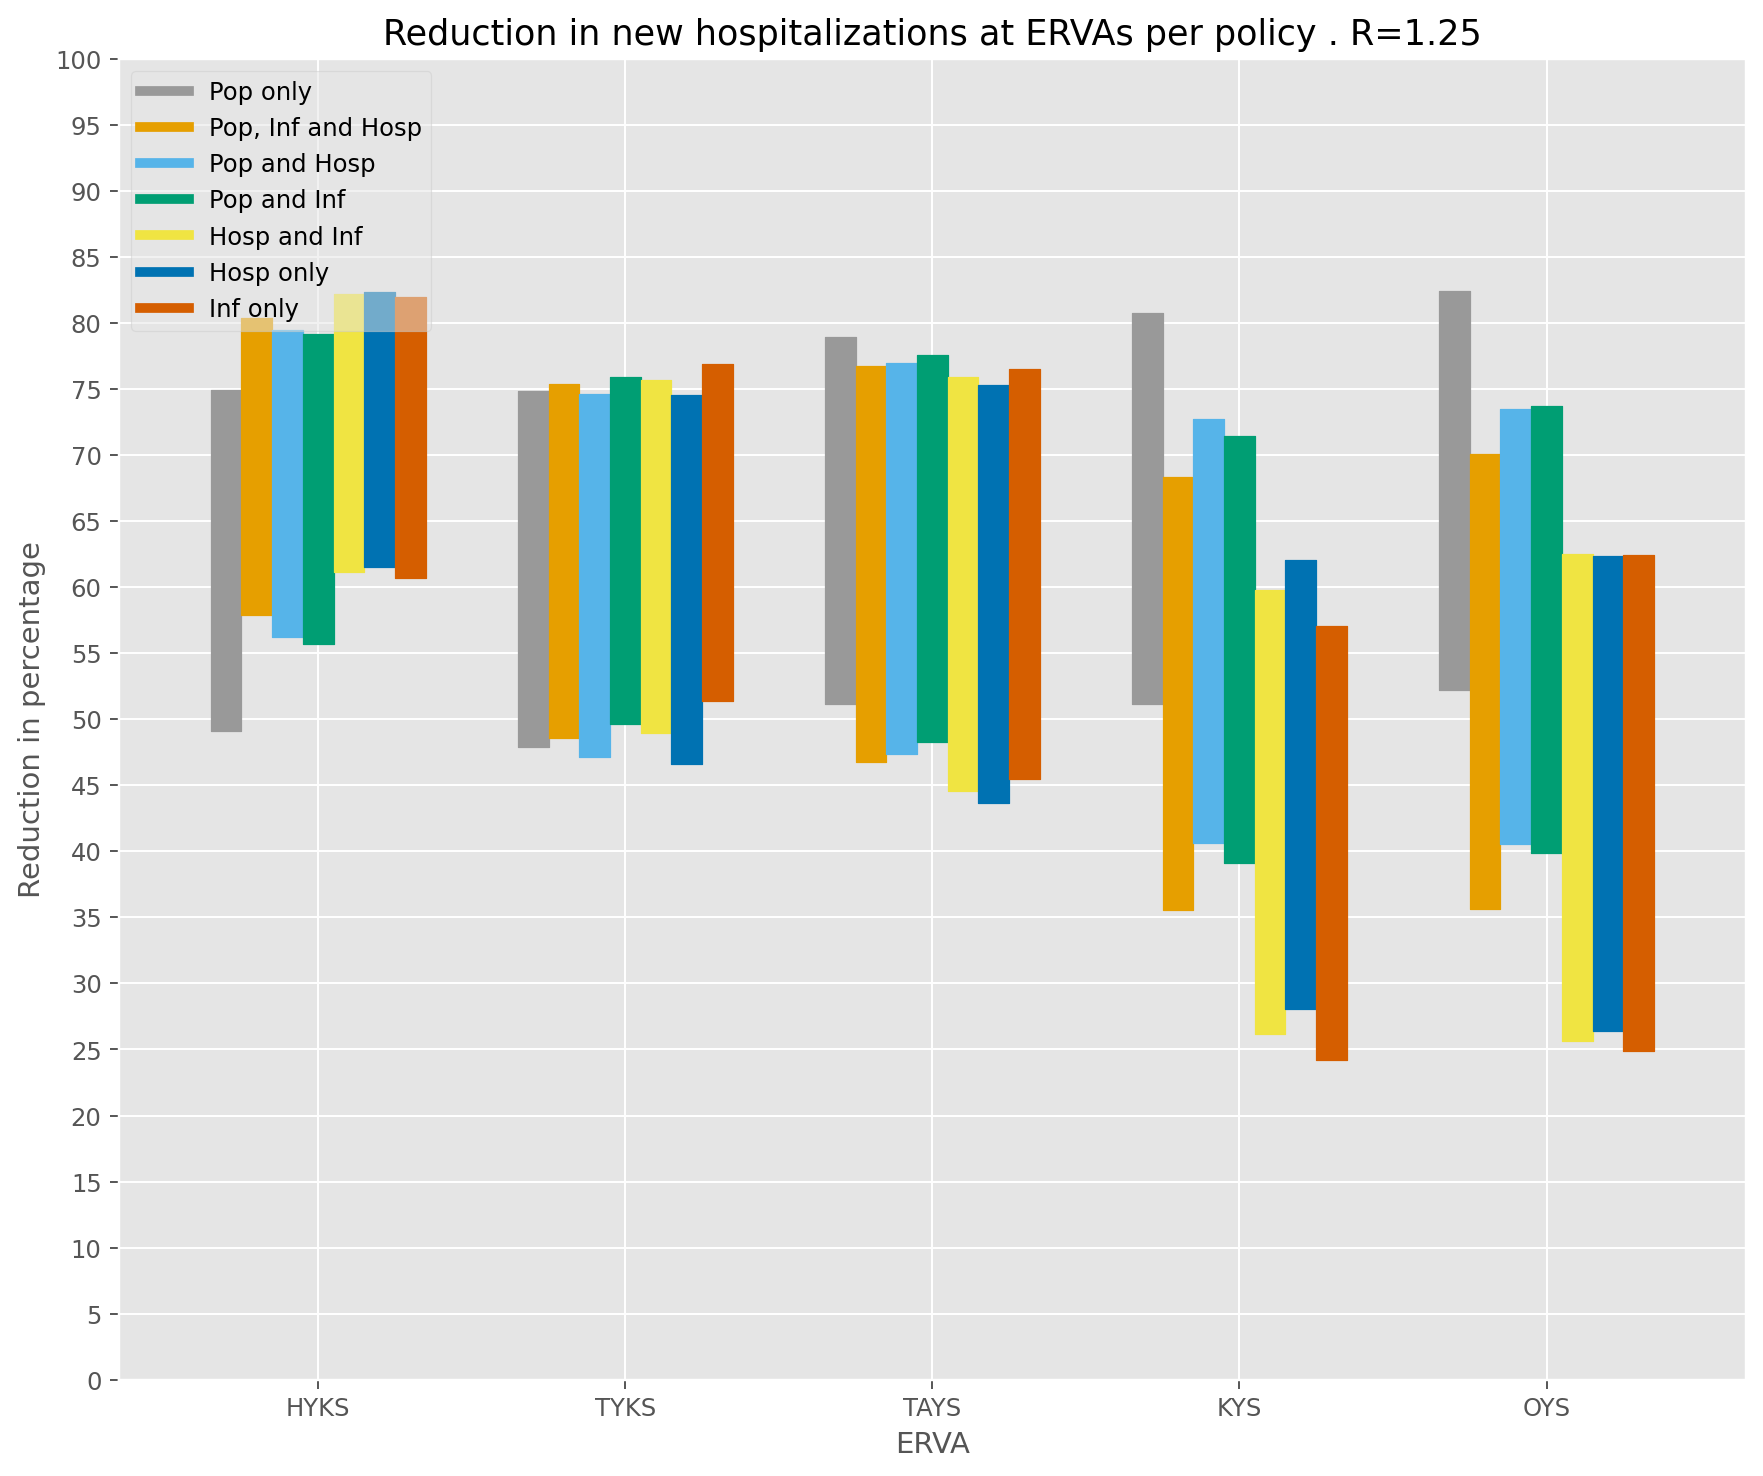

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[1], 'new hospitalizations', all_results, ervas_labels, 'ERVA')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


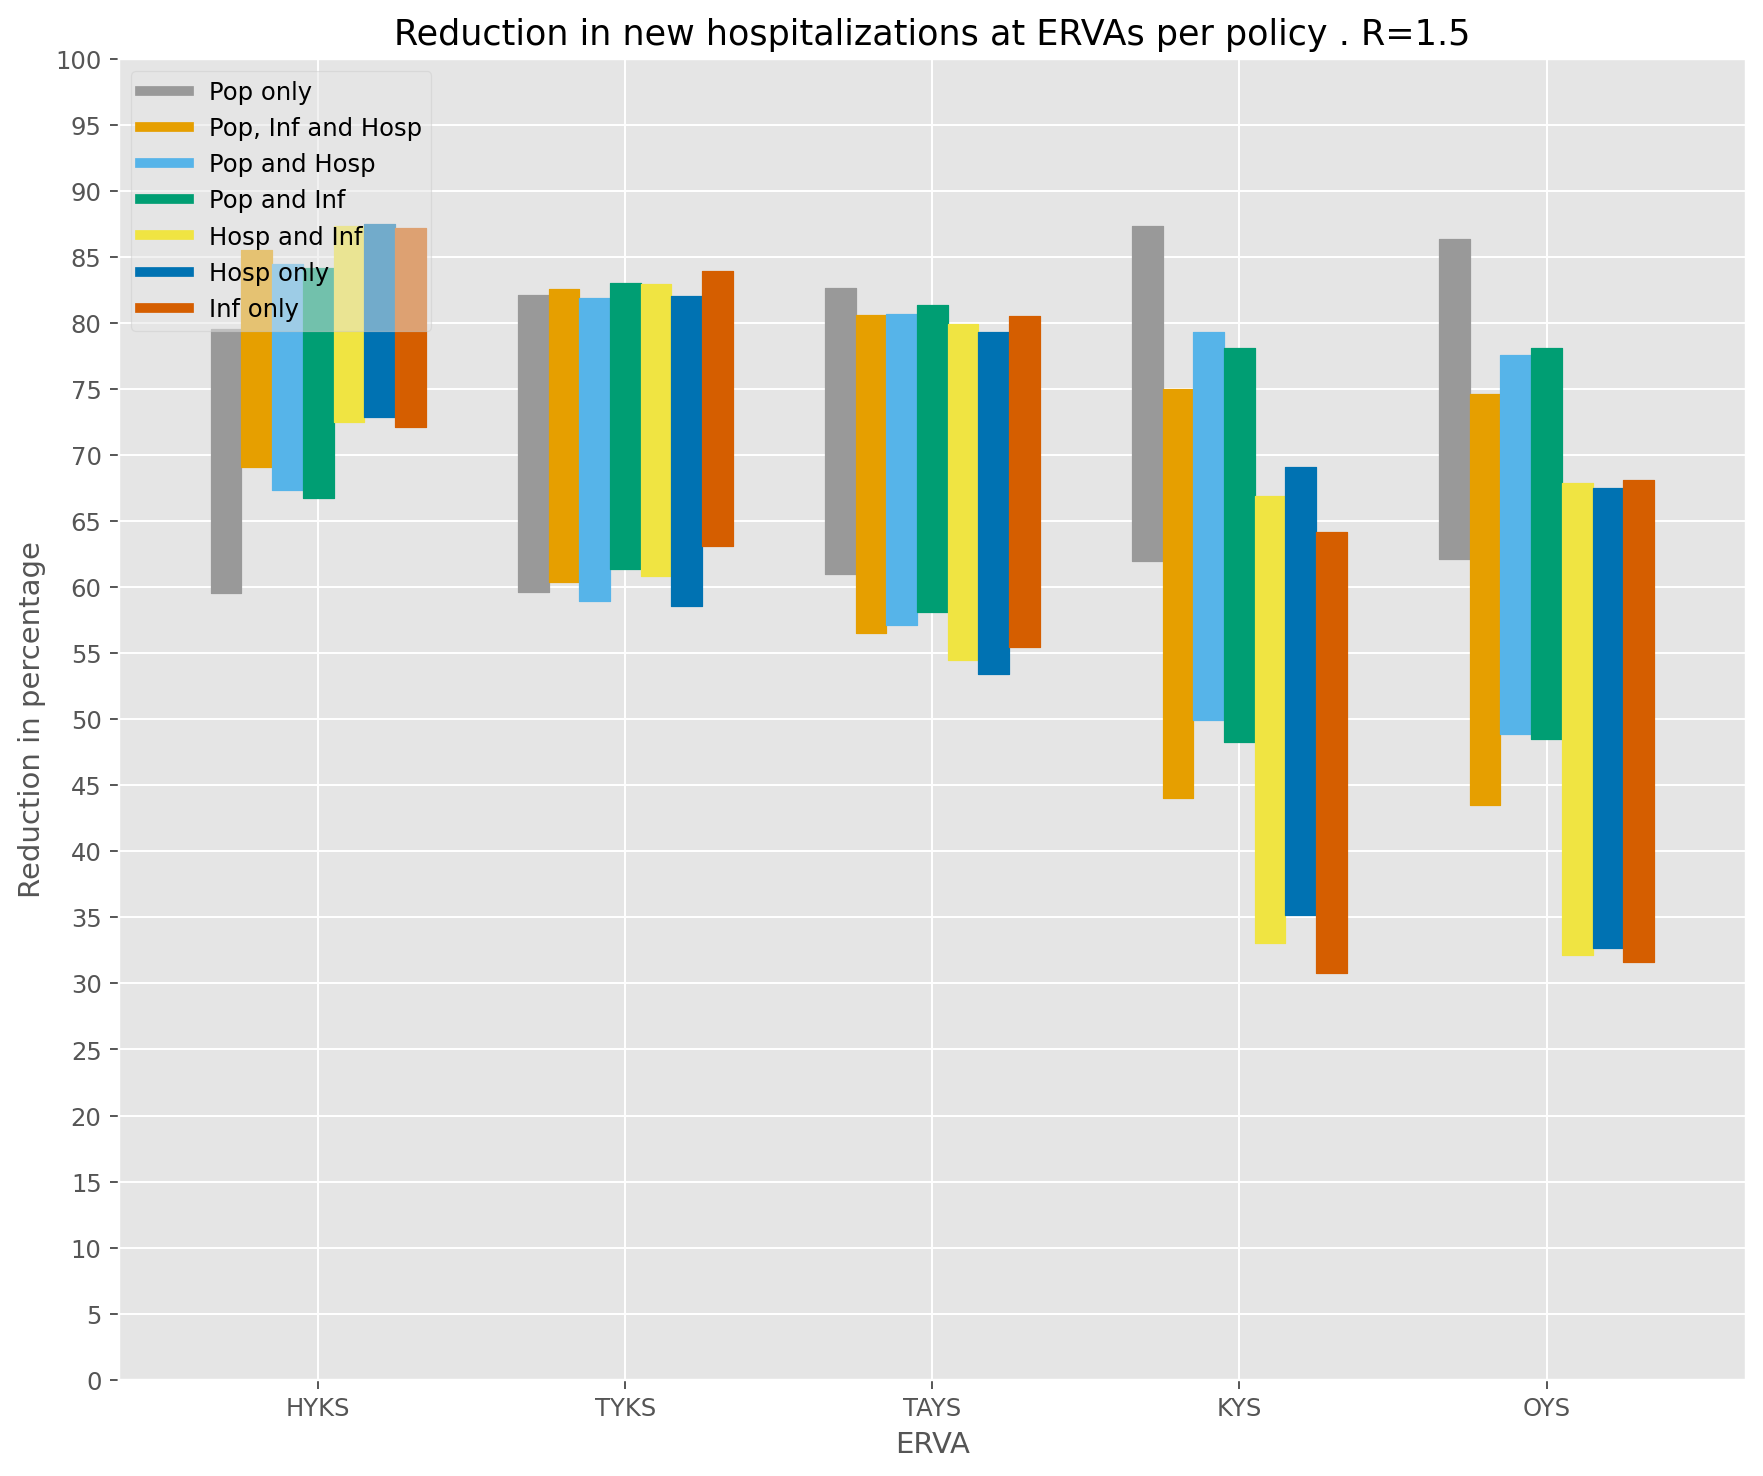

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[2], 'new hospitalizations', all_results, ervas_labels, 'ERVA')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


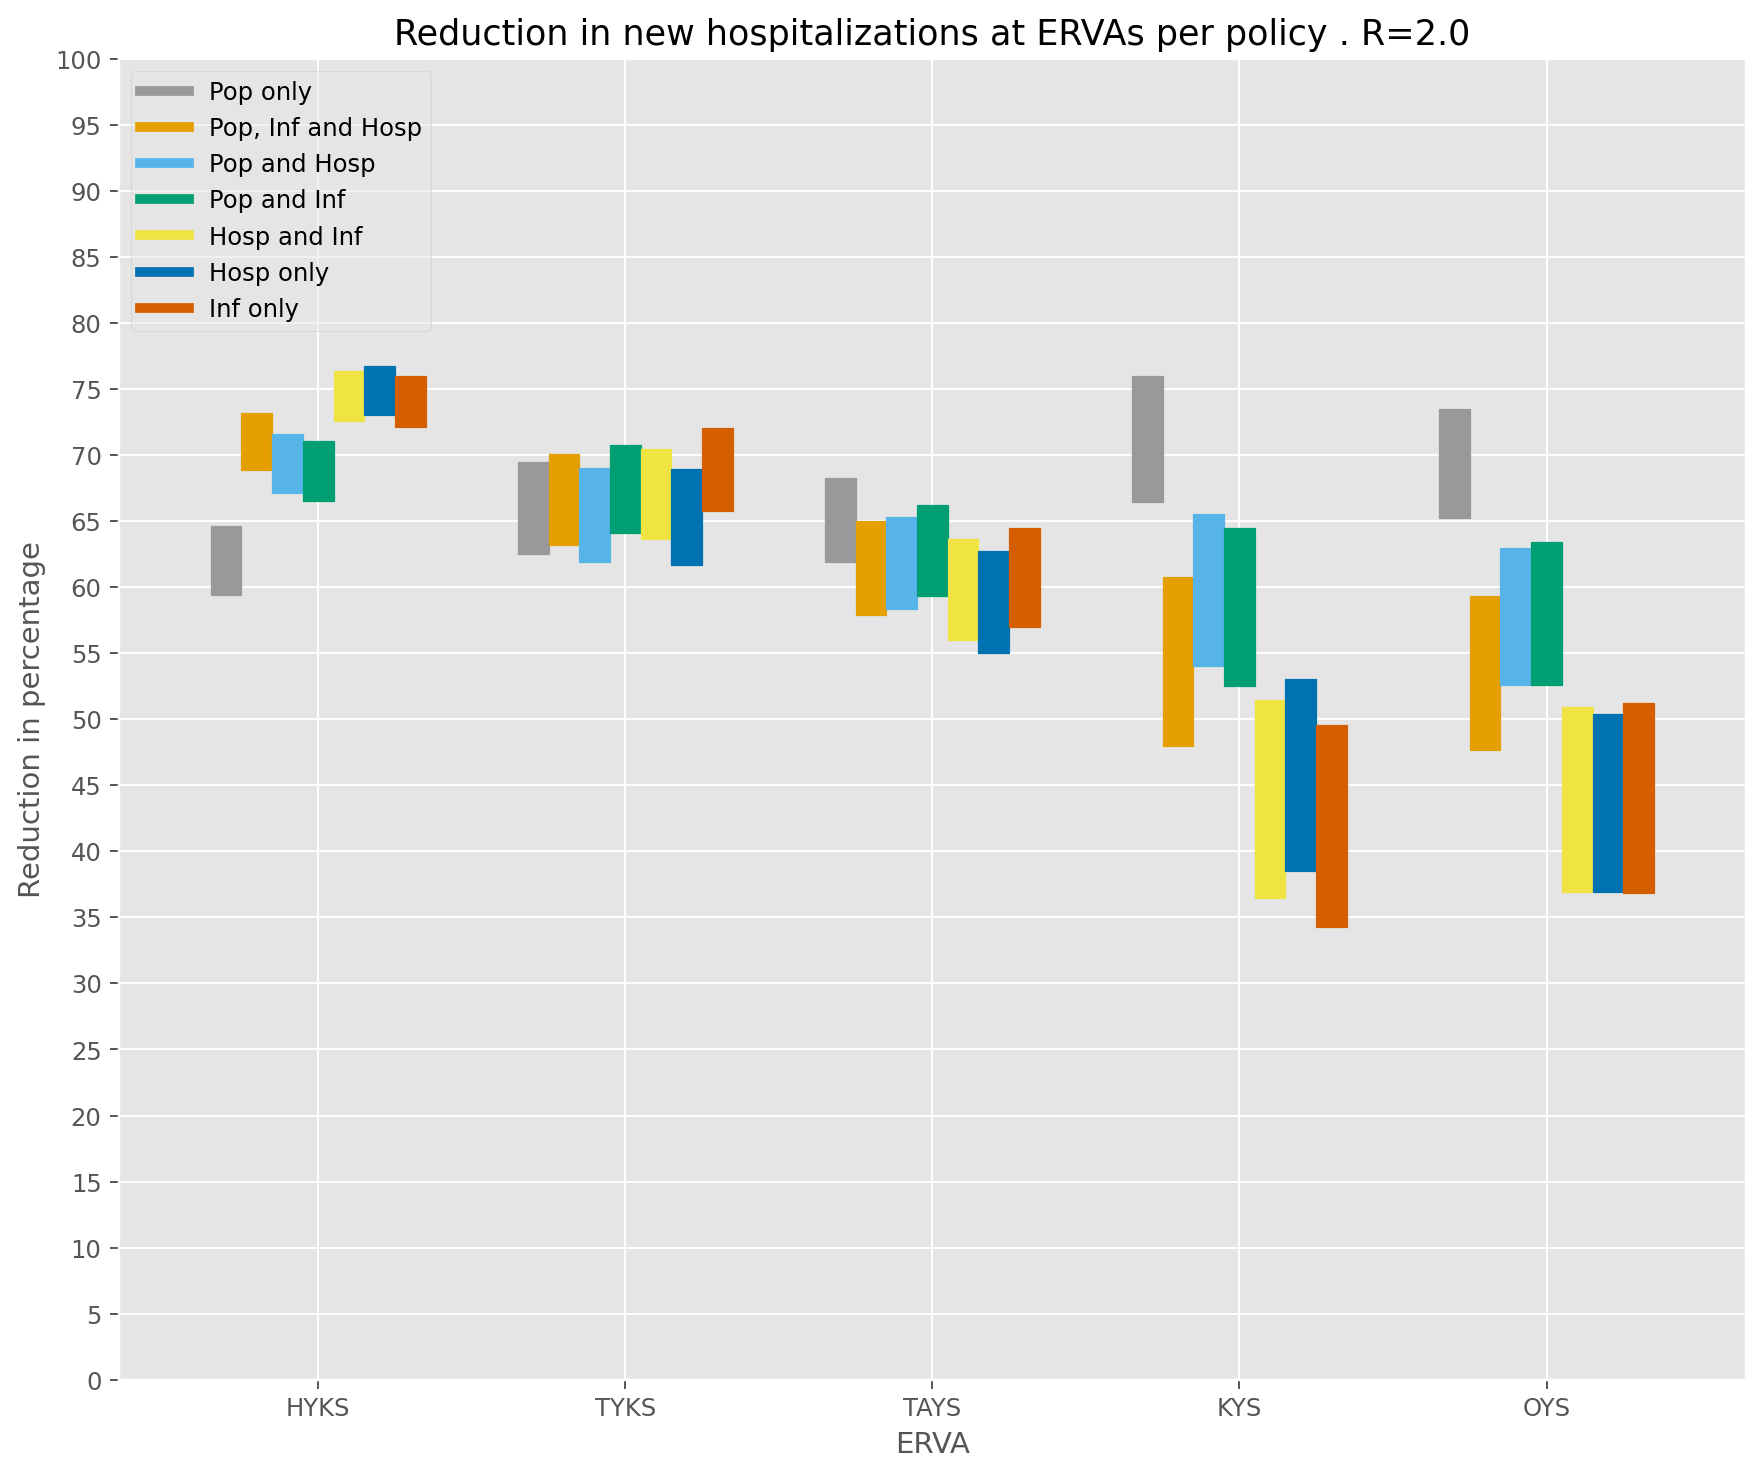

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[3], 'new hospitalizations', all_results, ervas_labels, 'ERVA')

# Infections at ERVAs

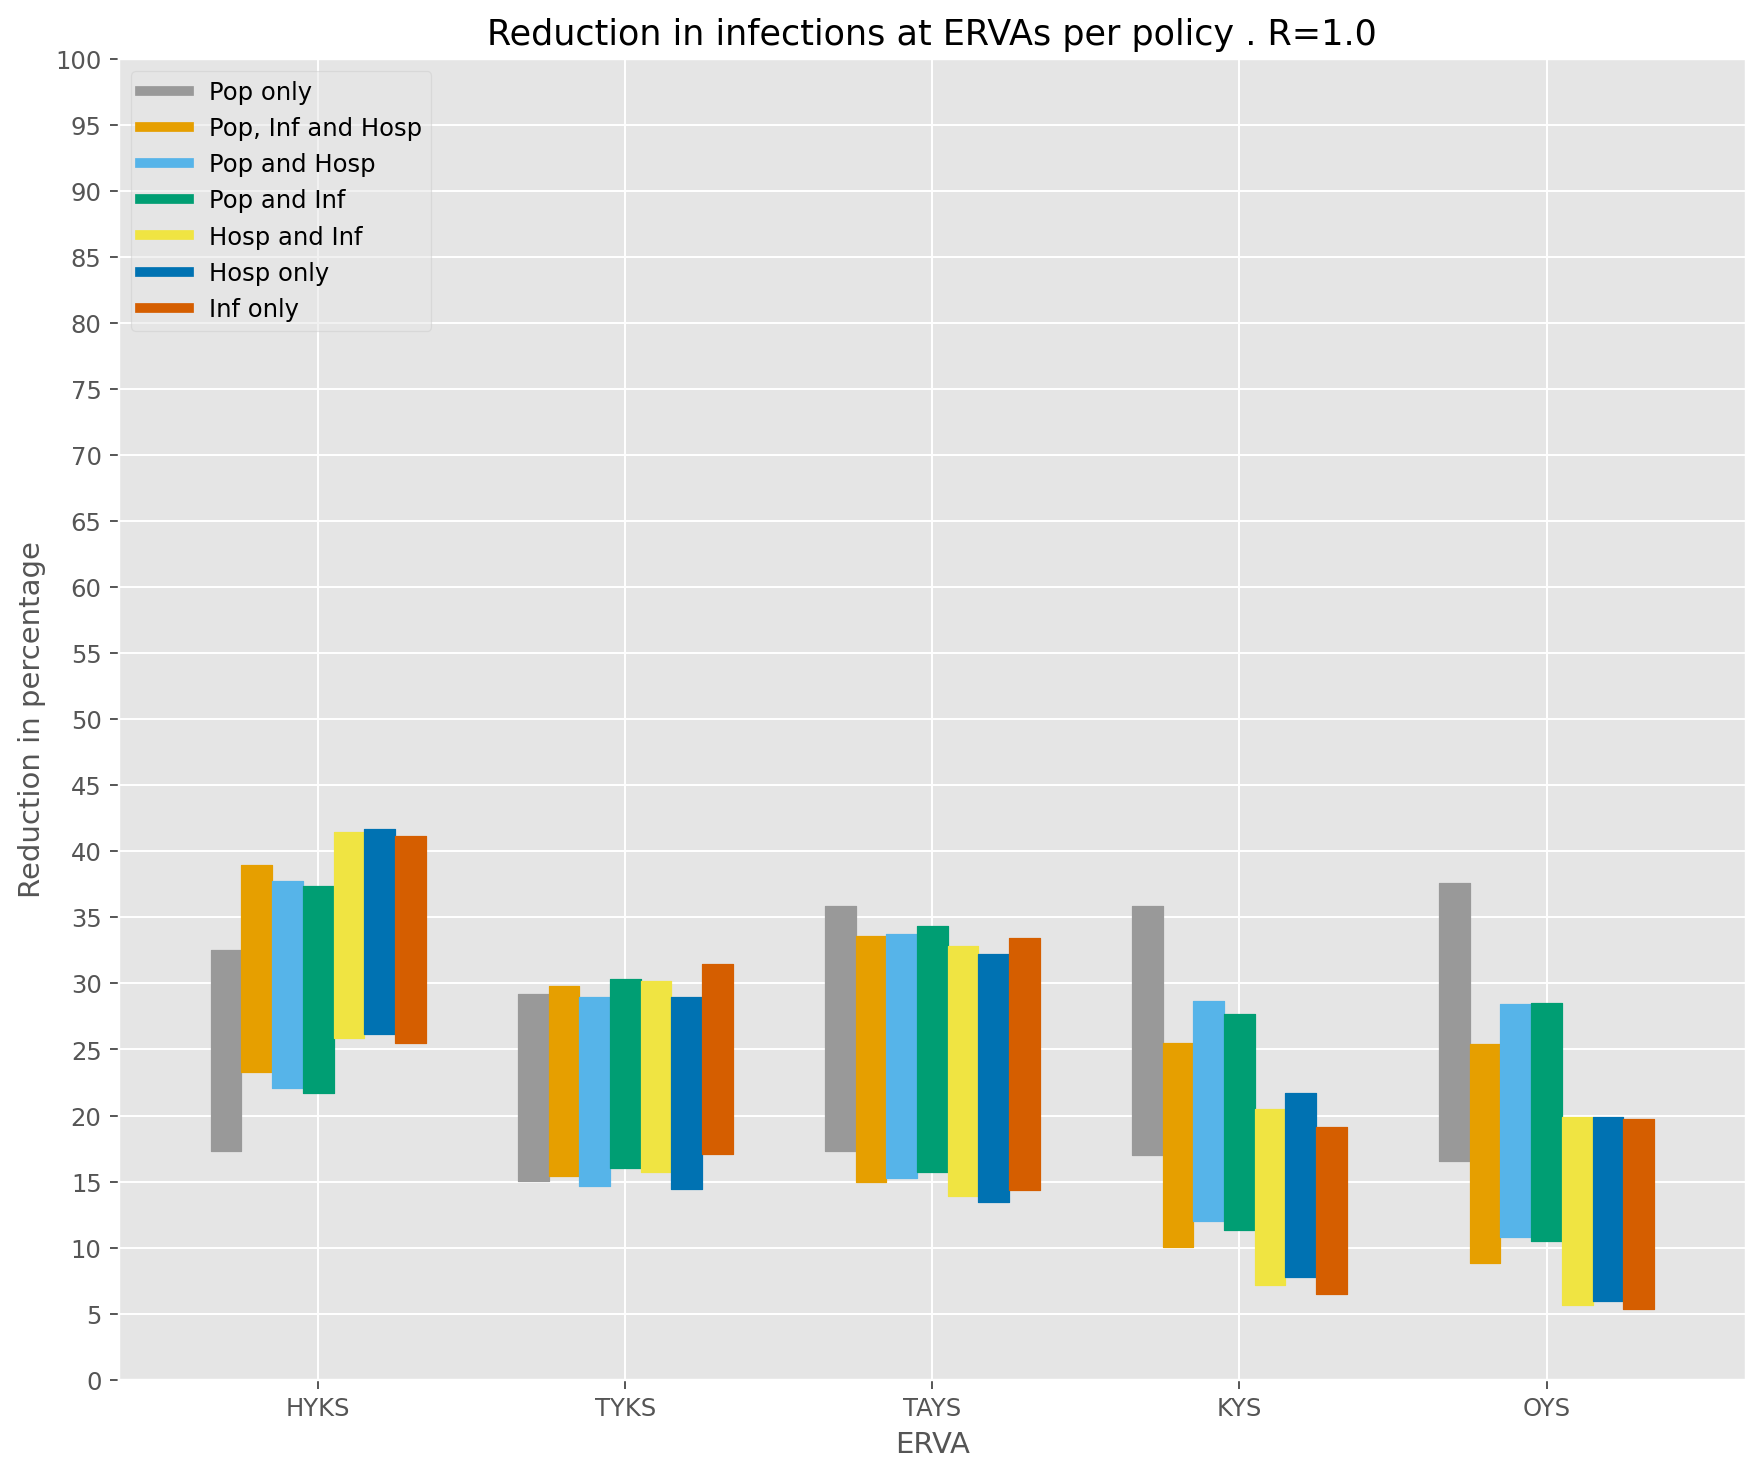

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[0], 'infections', all_results, ervas_labels, 'ERVA')

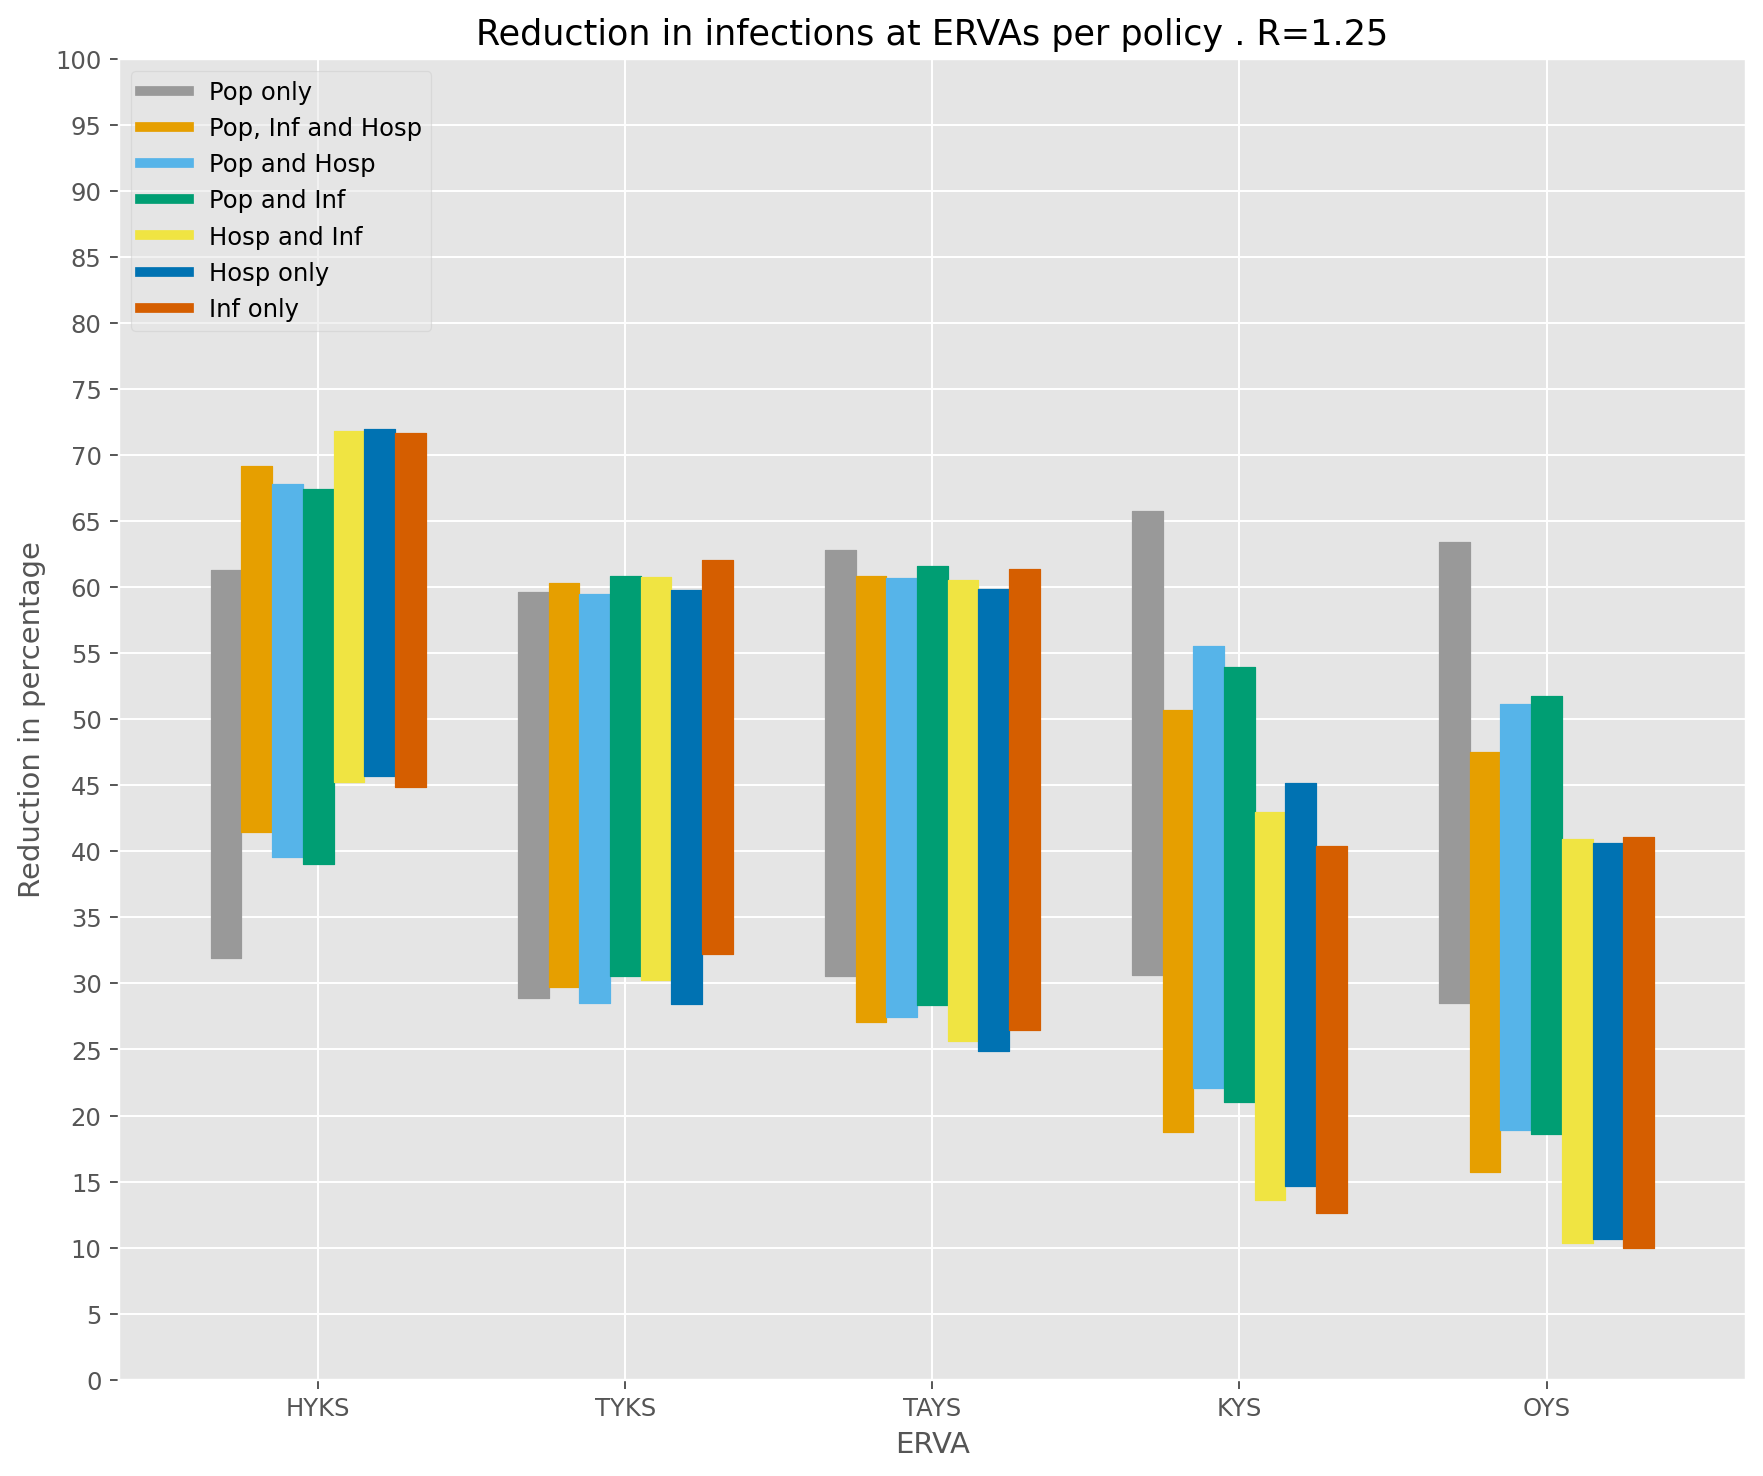

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[1], 'infections', all_results, ervas_labels, 'ERVA')

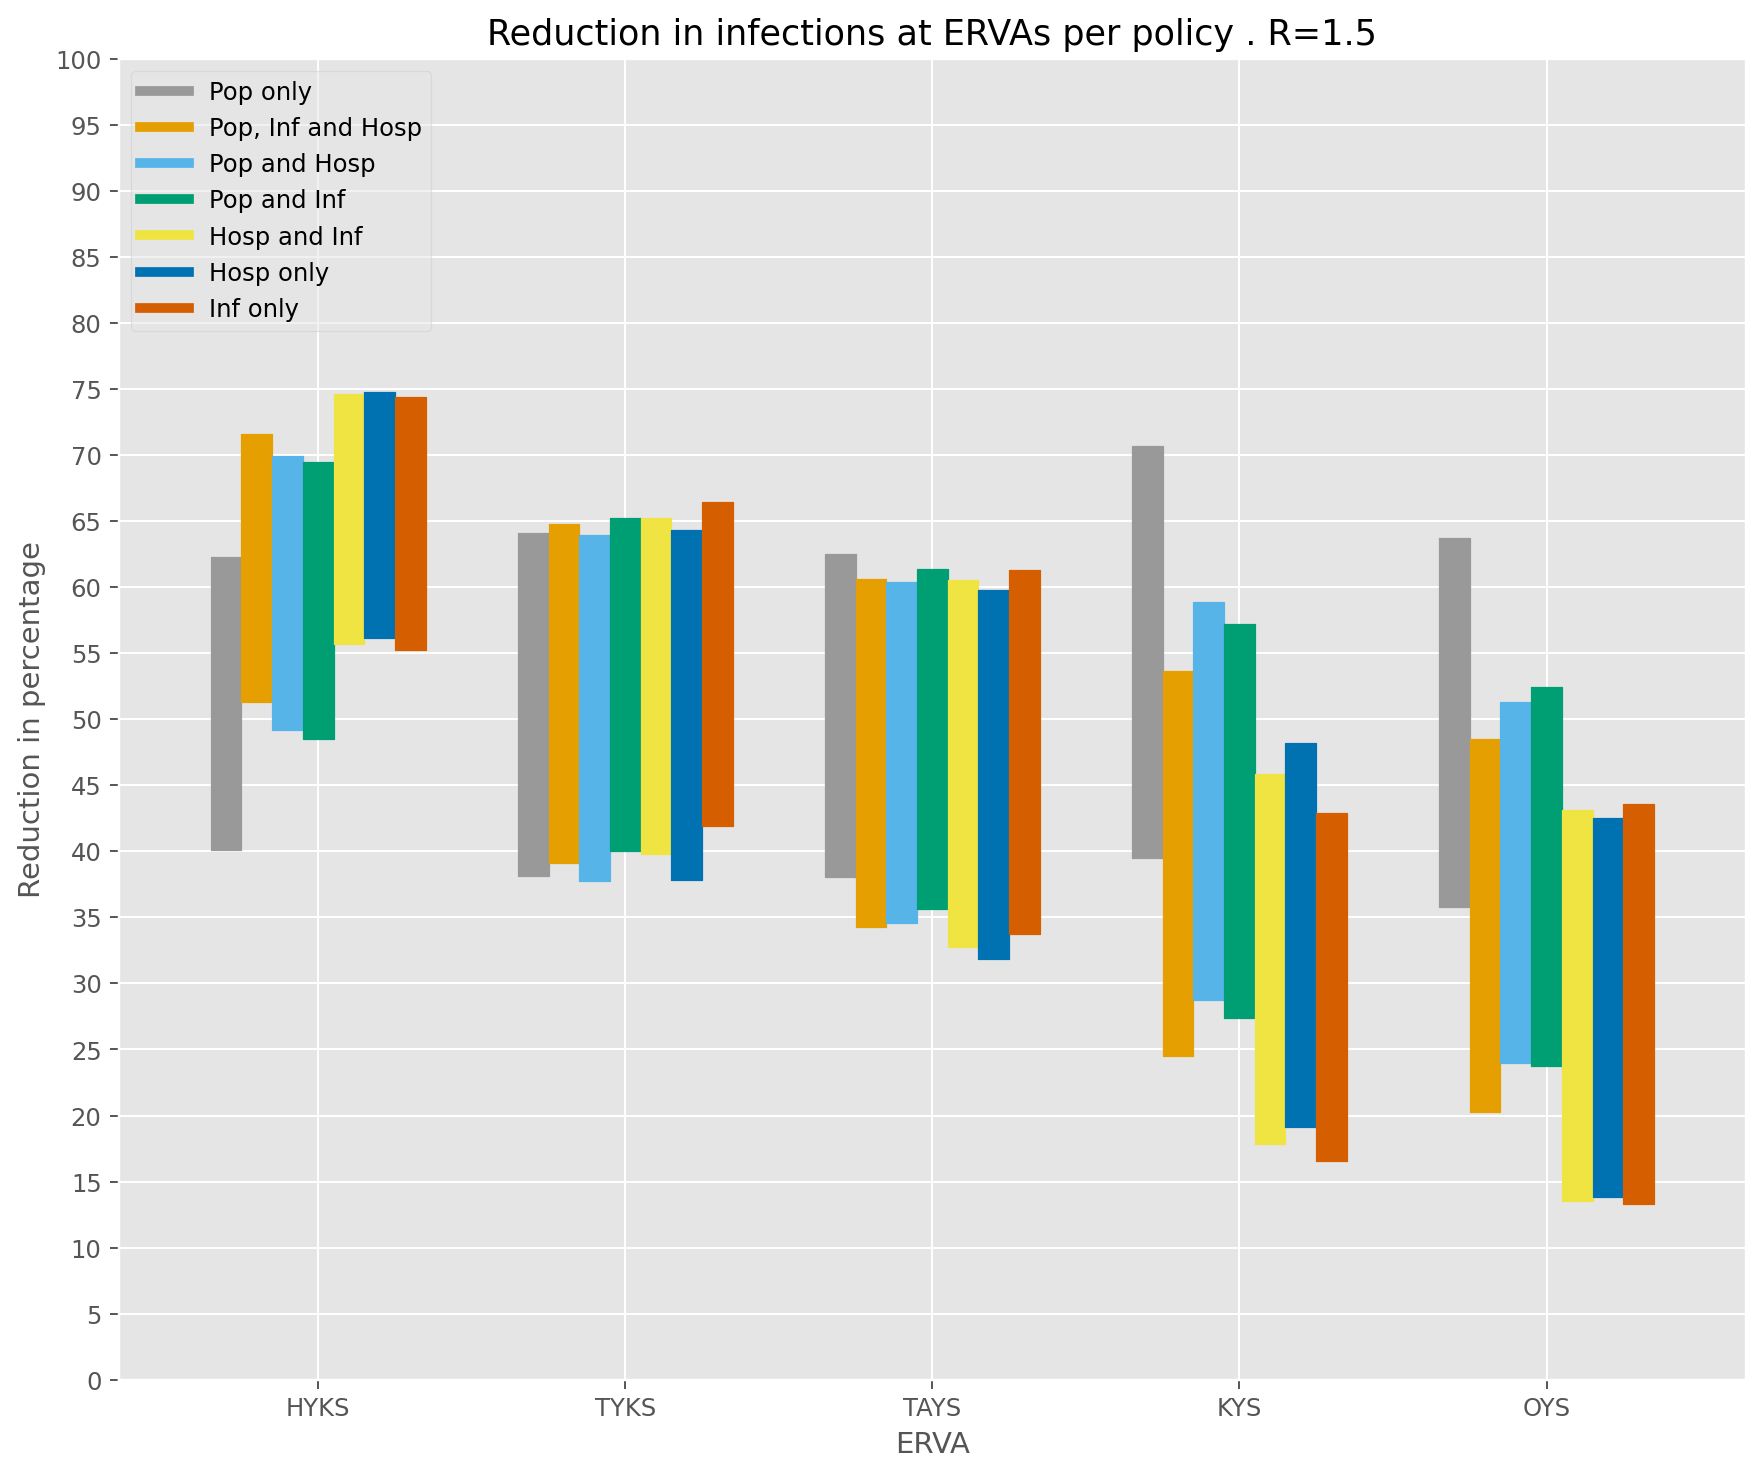

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[2], 'infections', all_results, ervas_labels, 'ERVA')

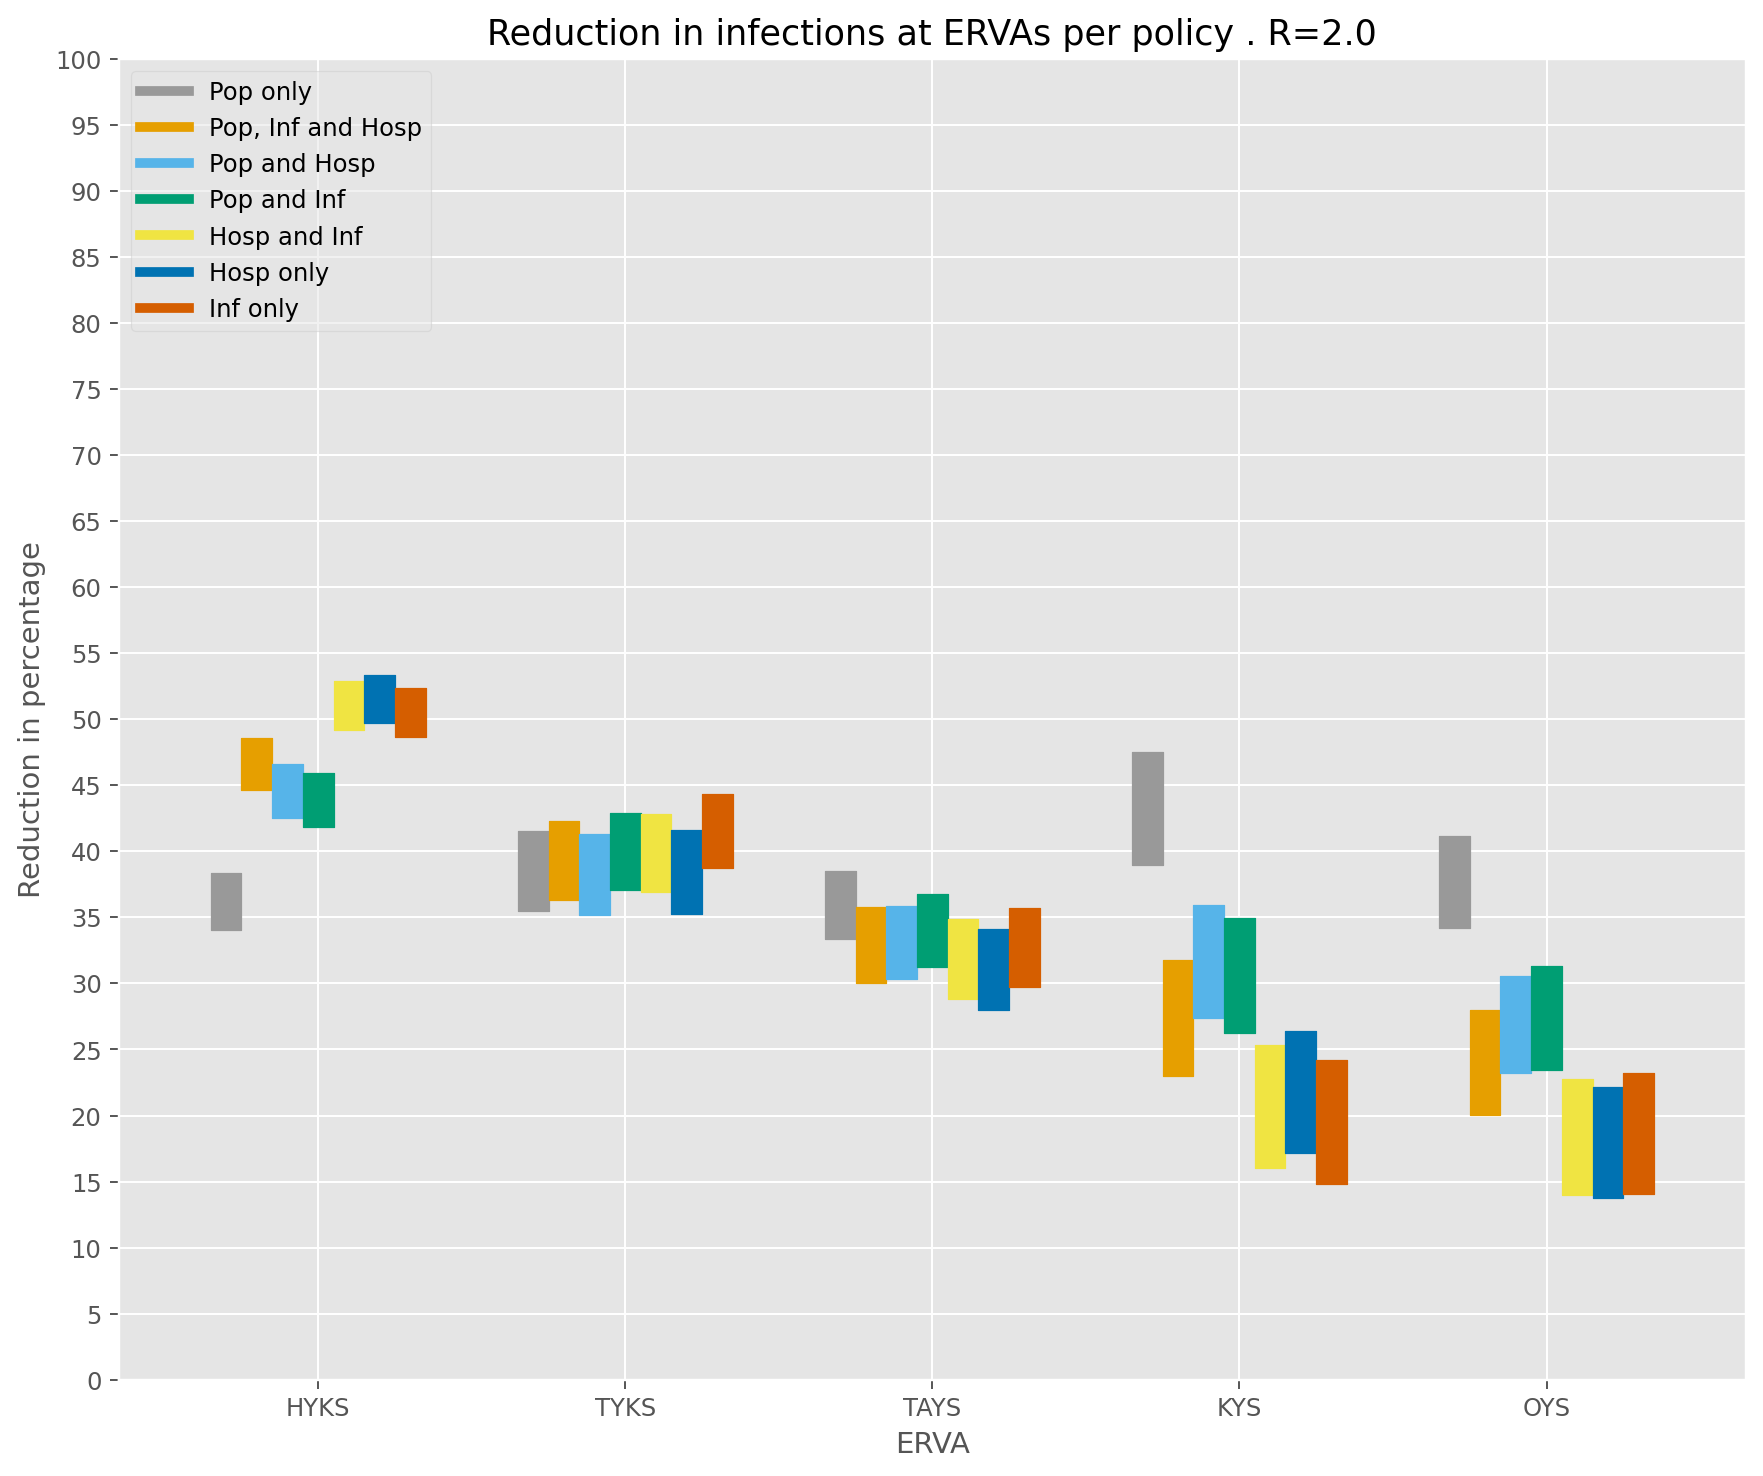

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[3], 'infections', all_results, ervas_labels, 'ERVA')

# Deaths at age groups

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


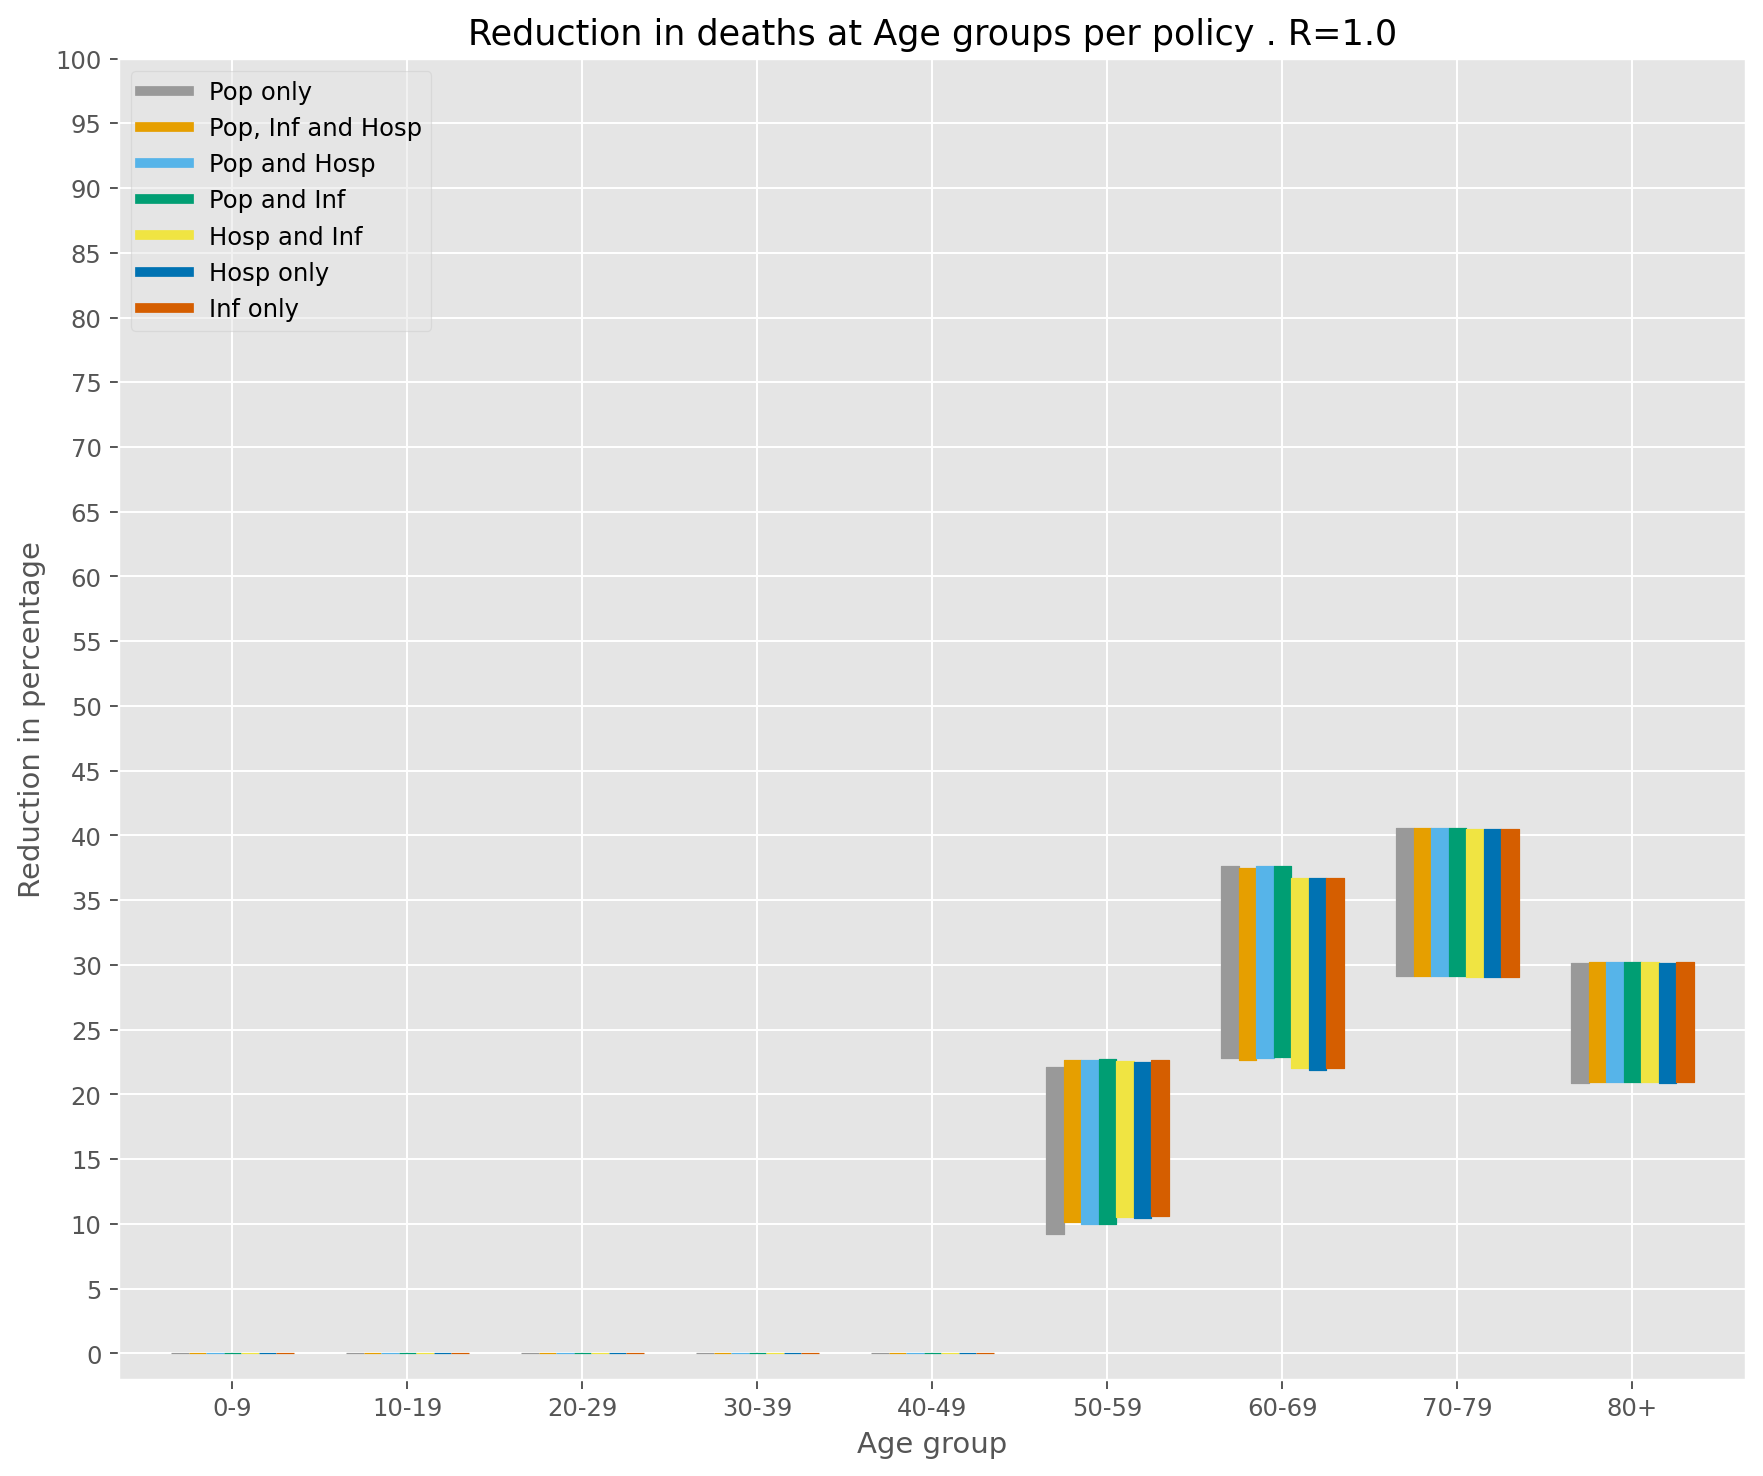

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[0], 'deaths', all_results, age_labels, 'Age group')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


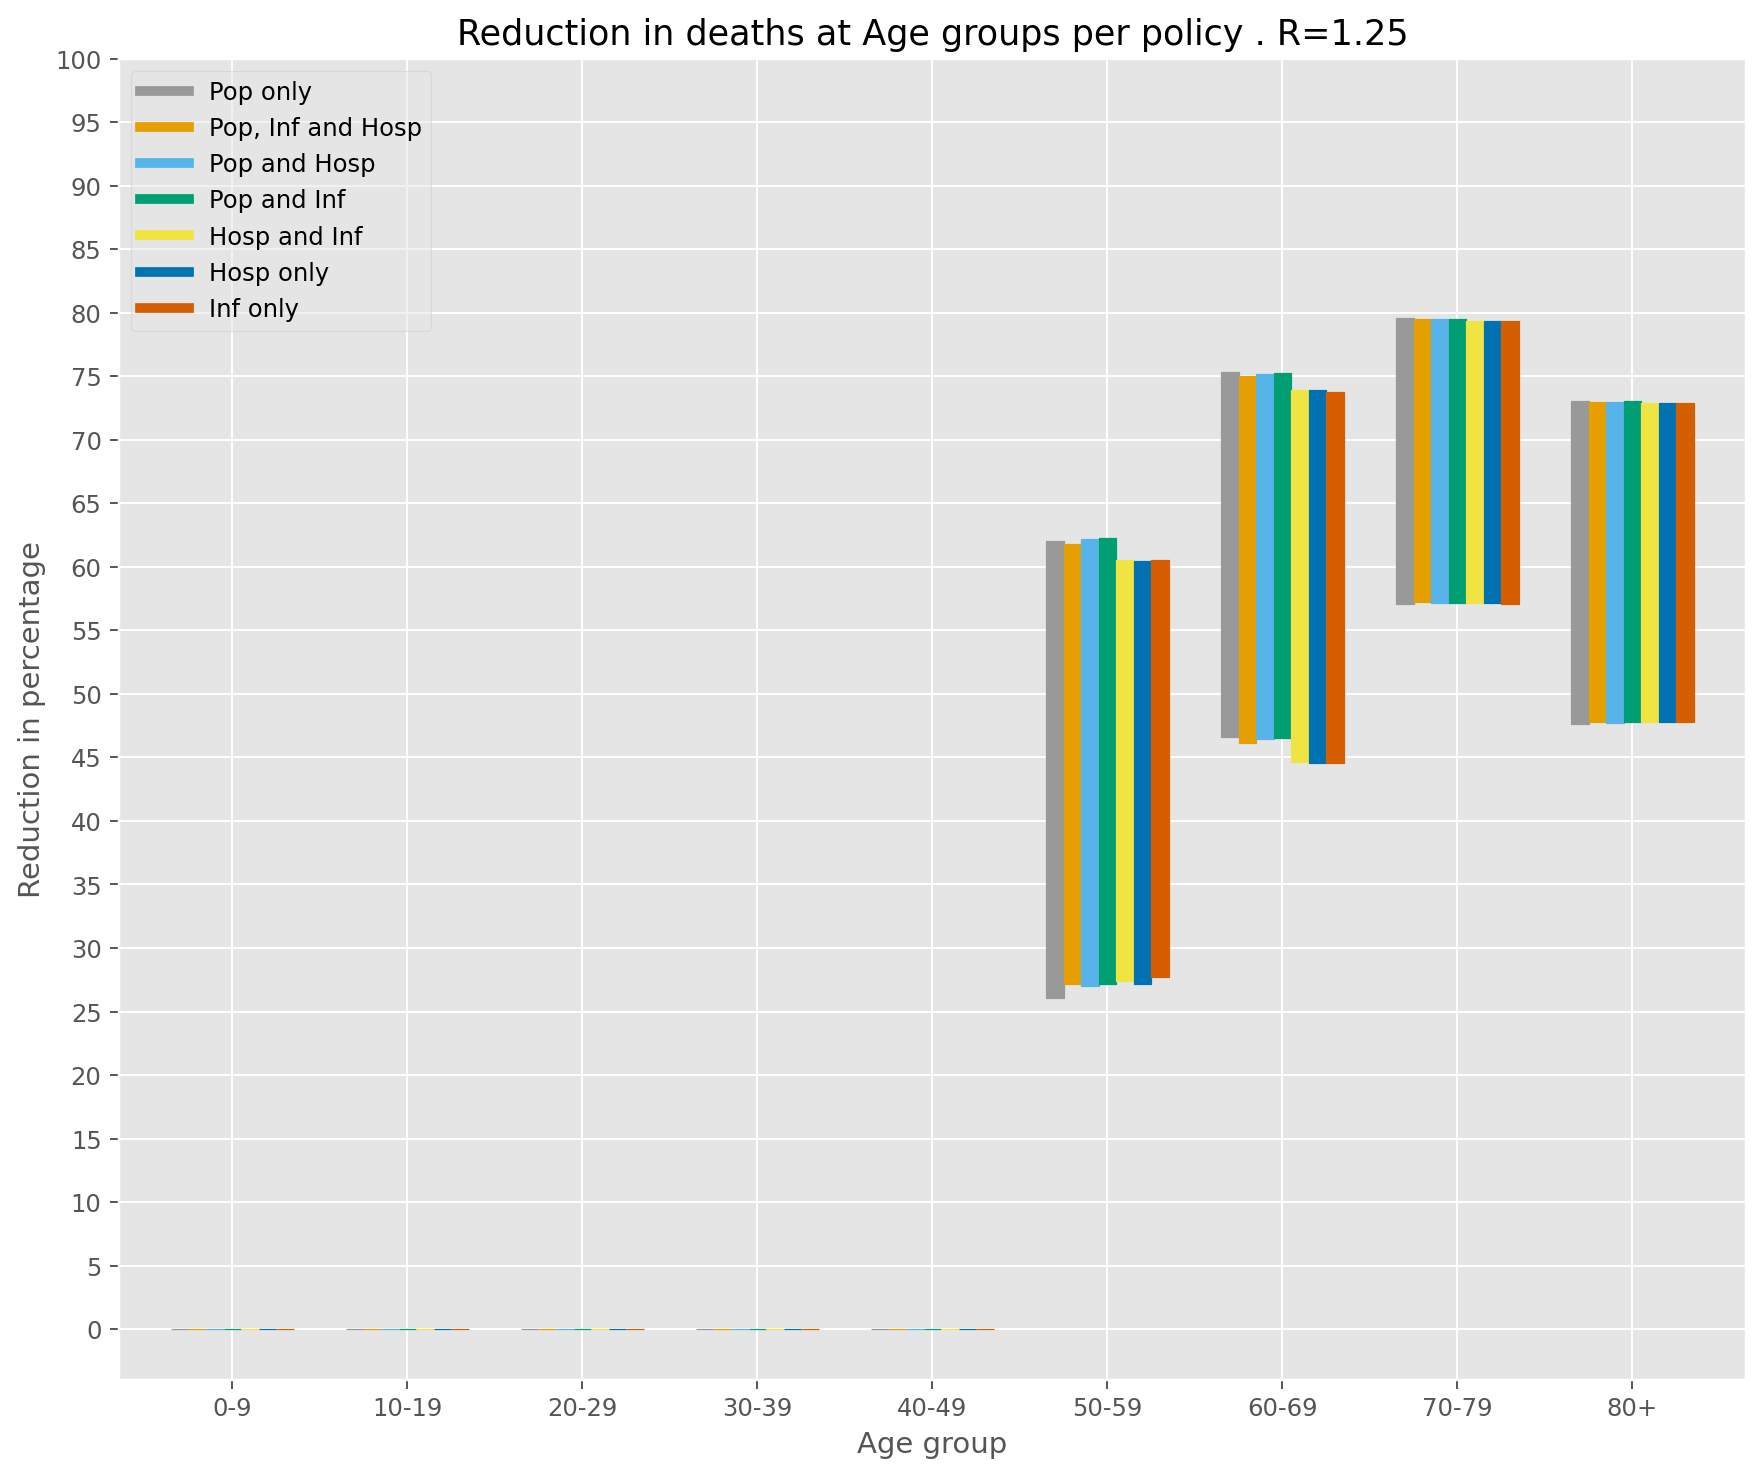

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[1], 'deaths', all_results, age_labels, 'Age group')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


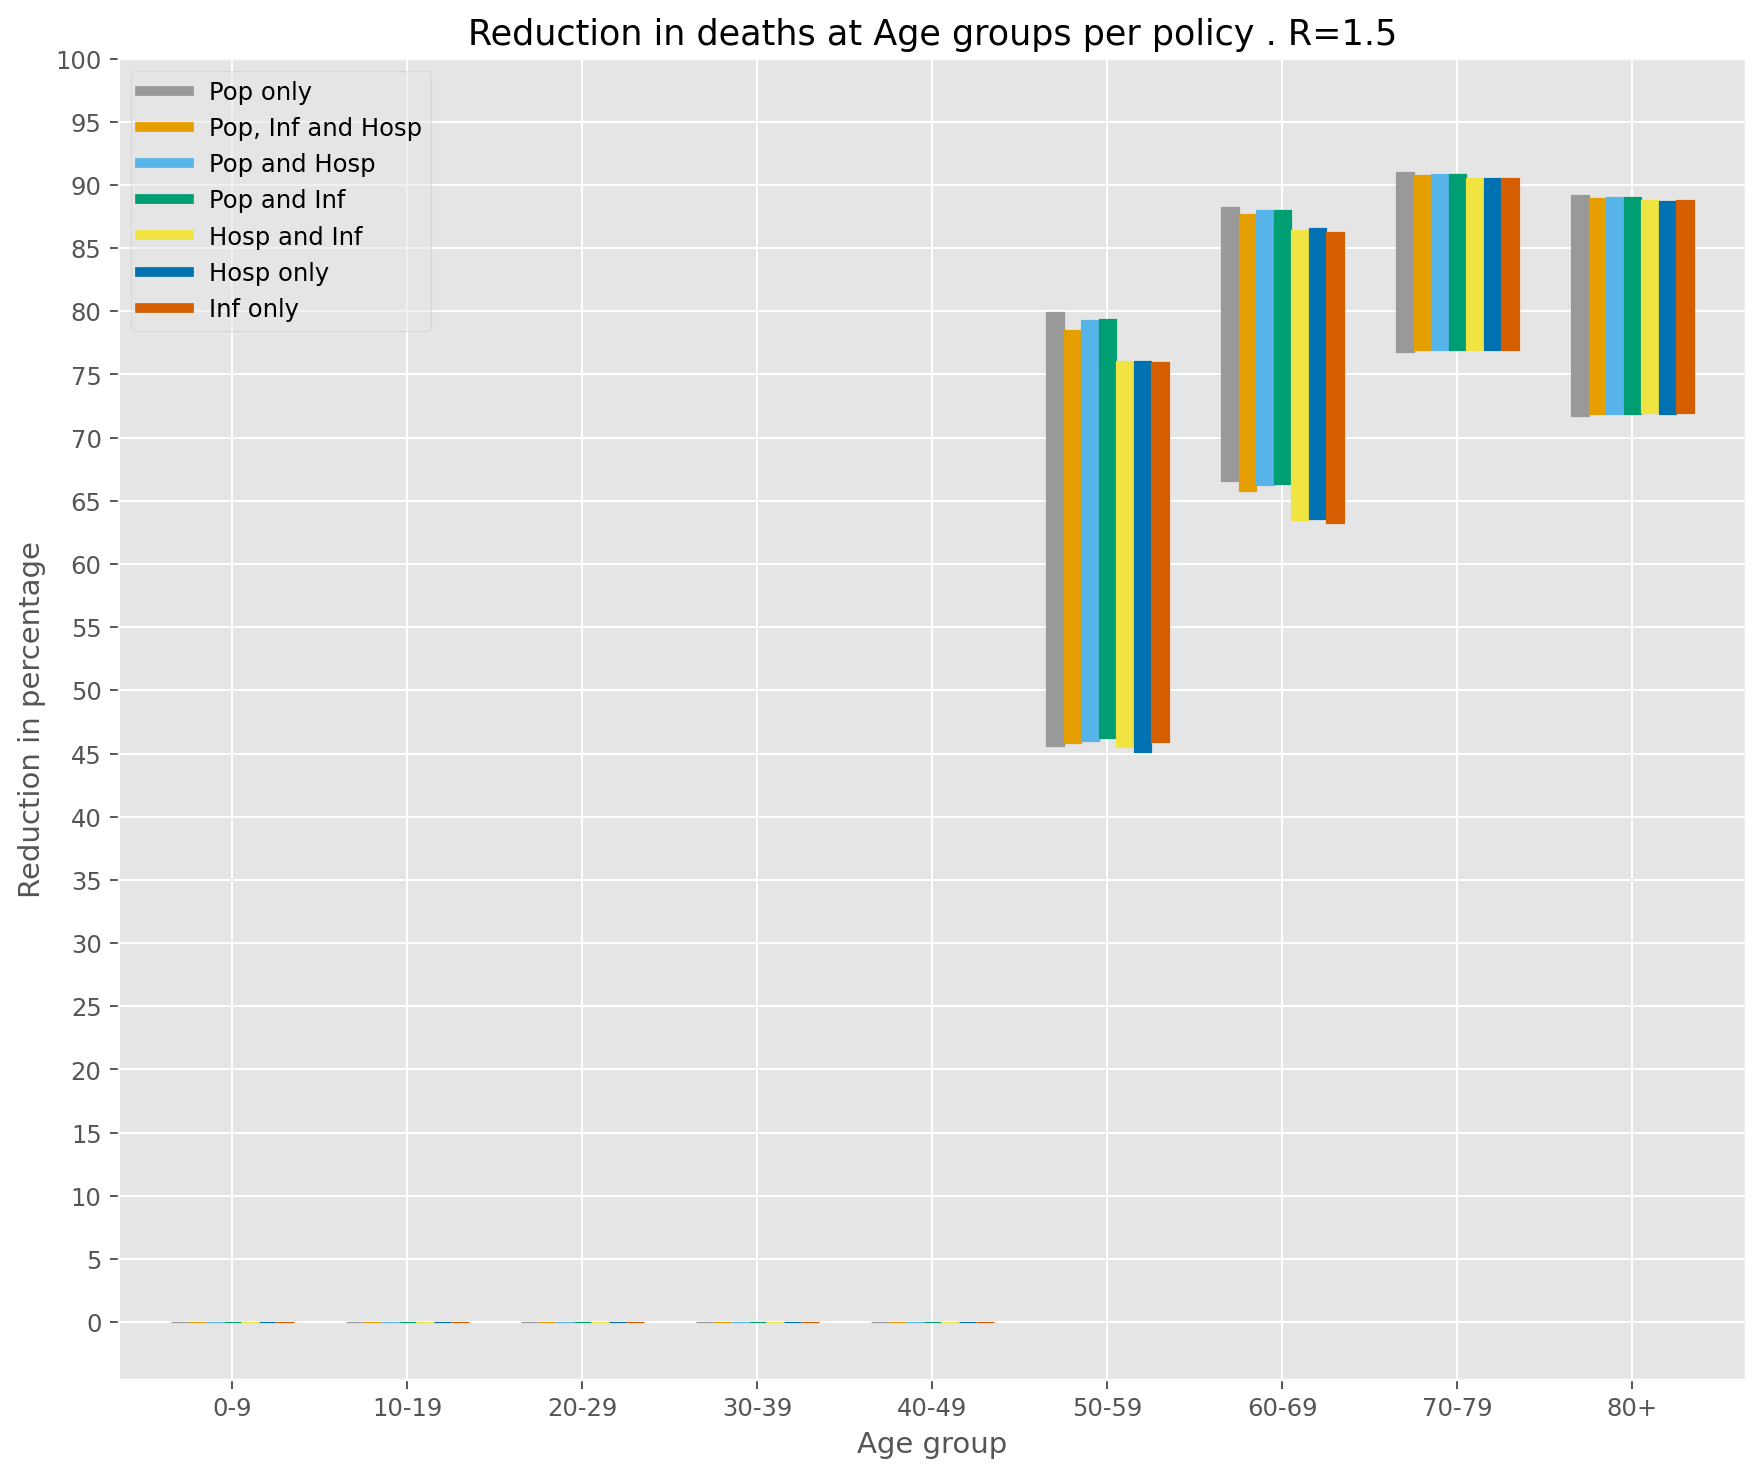

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[2], 'deaths', all_results, age_labels, 'Age group')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


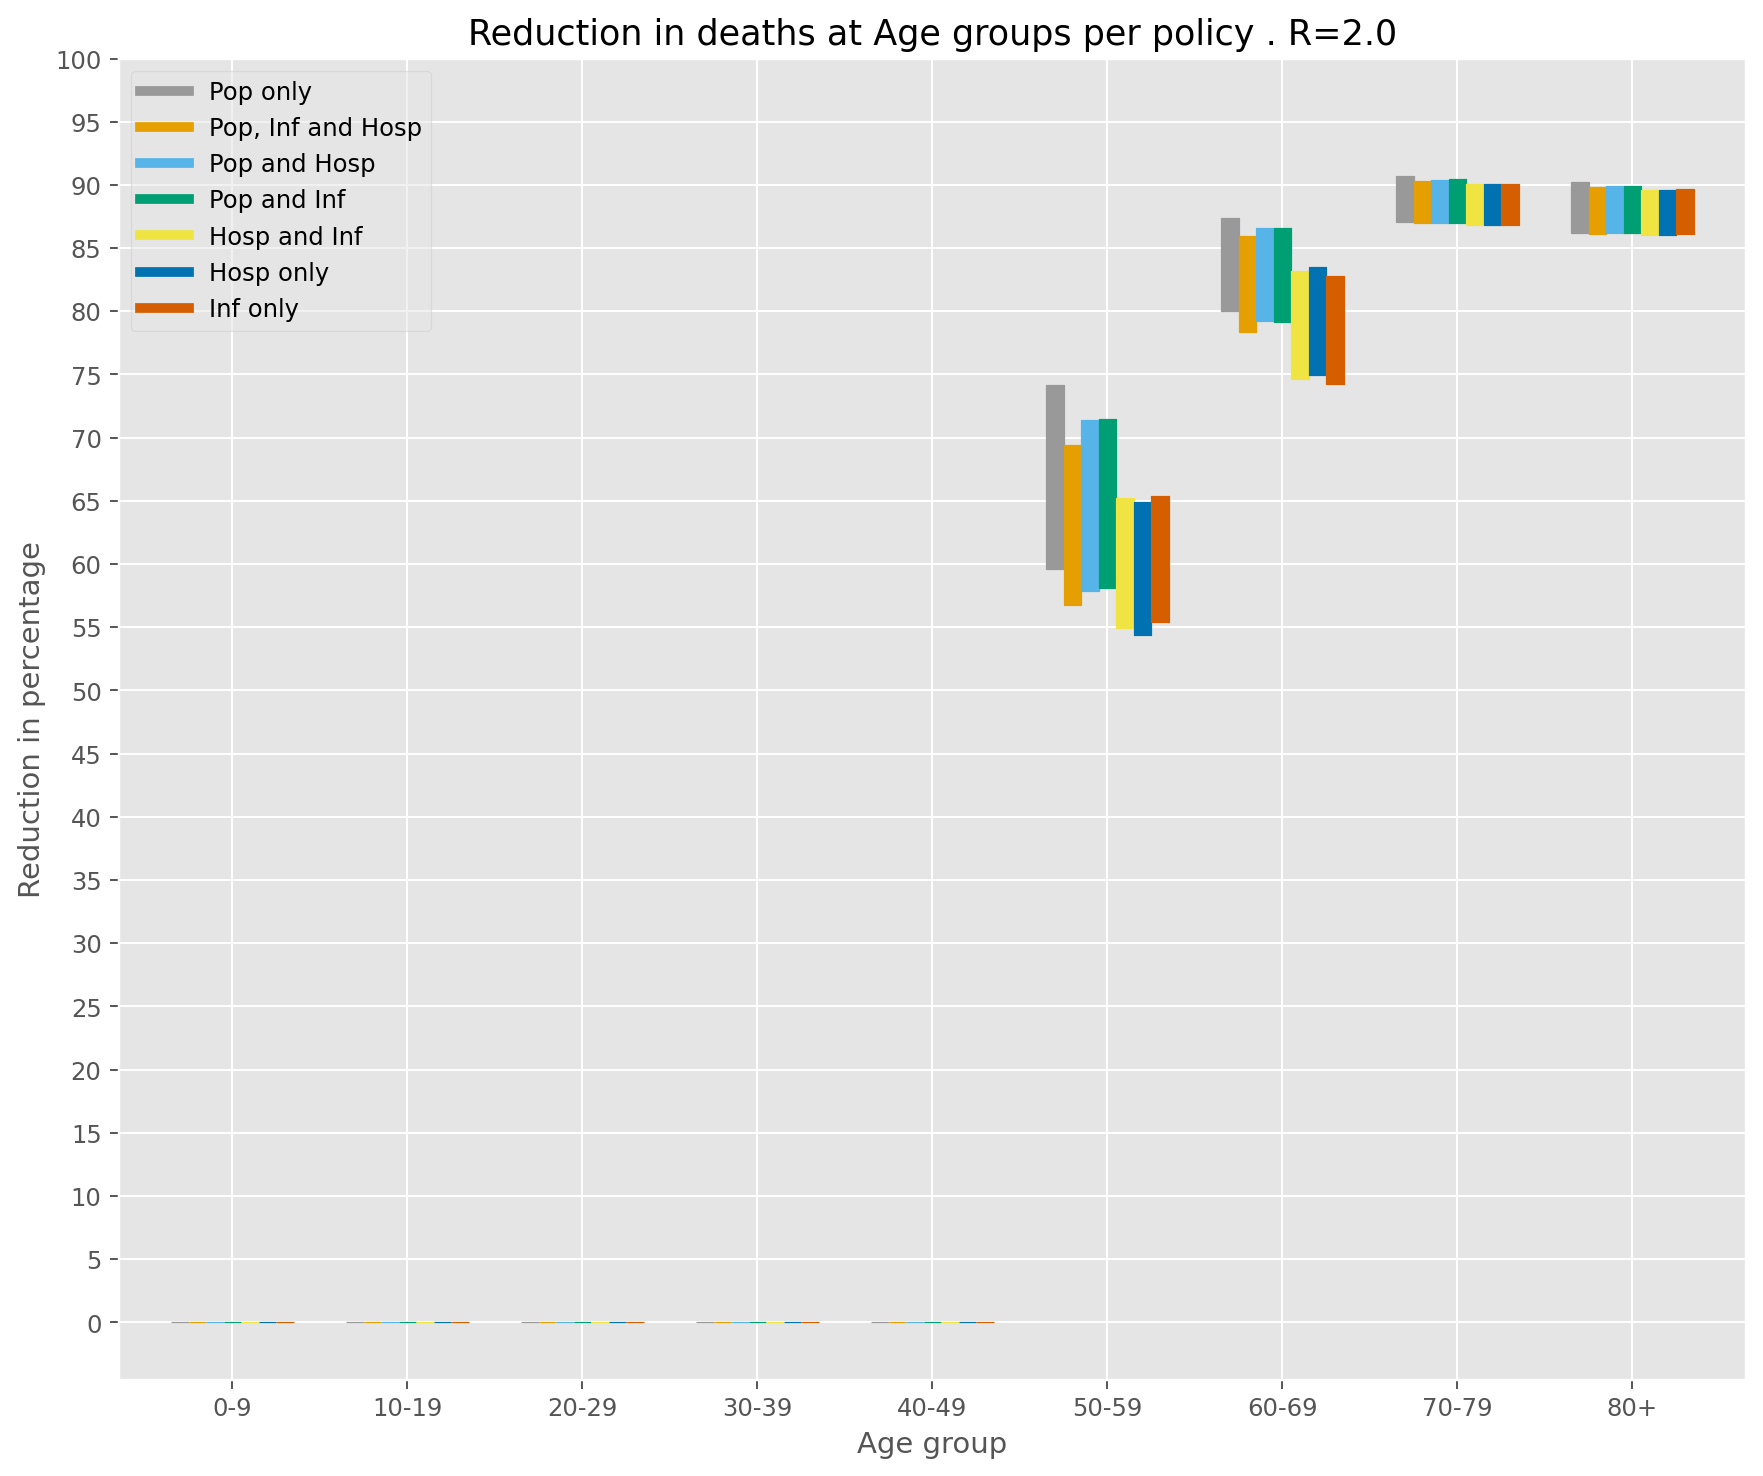

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[3], 'deaths', all_results, age_labels, 'Age group')

# Hospitalizations at age groups

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


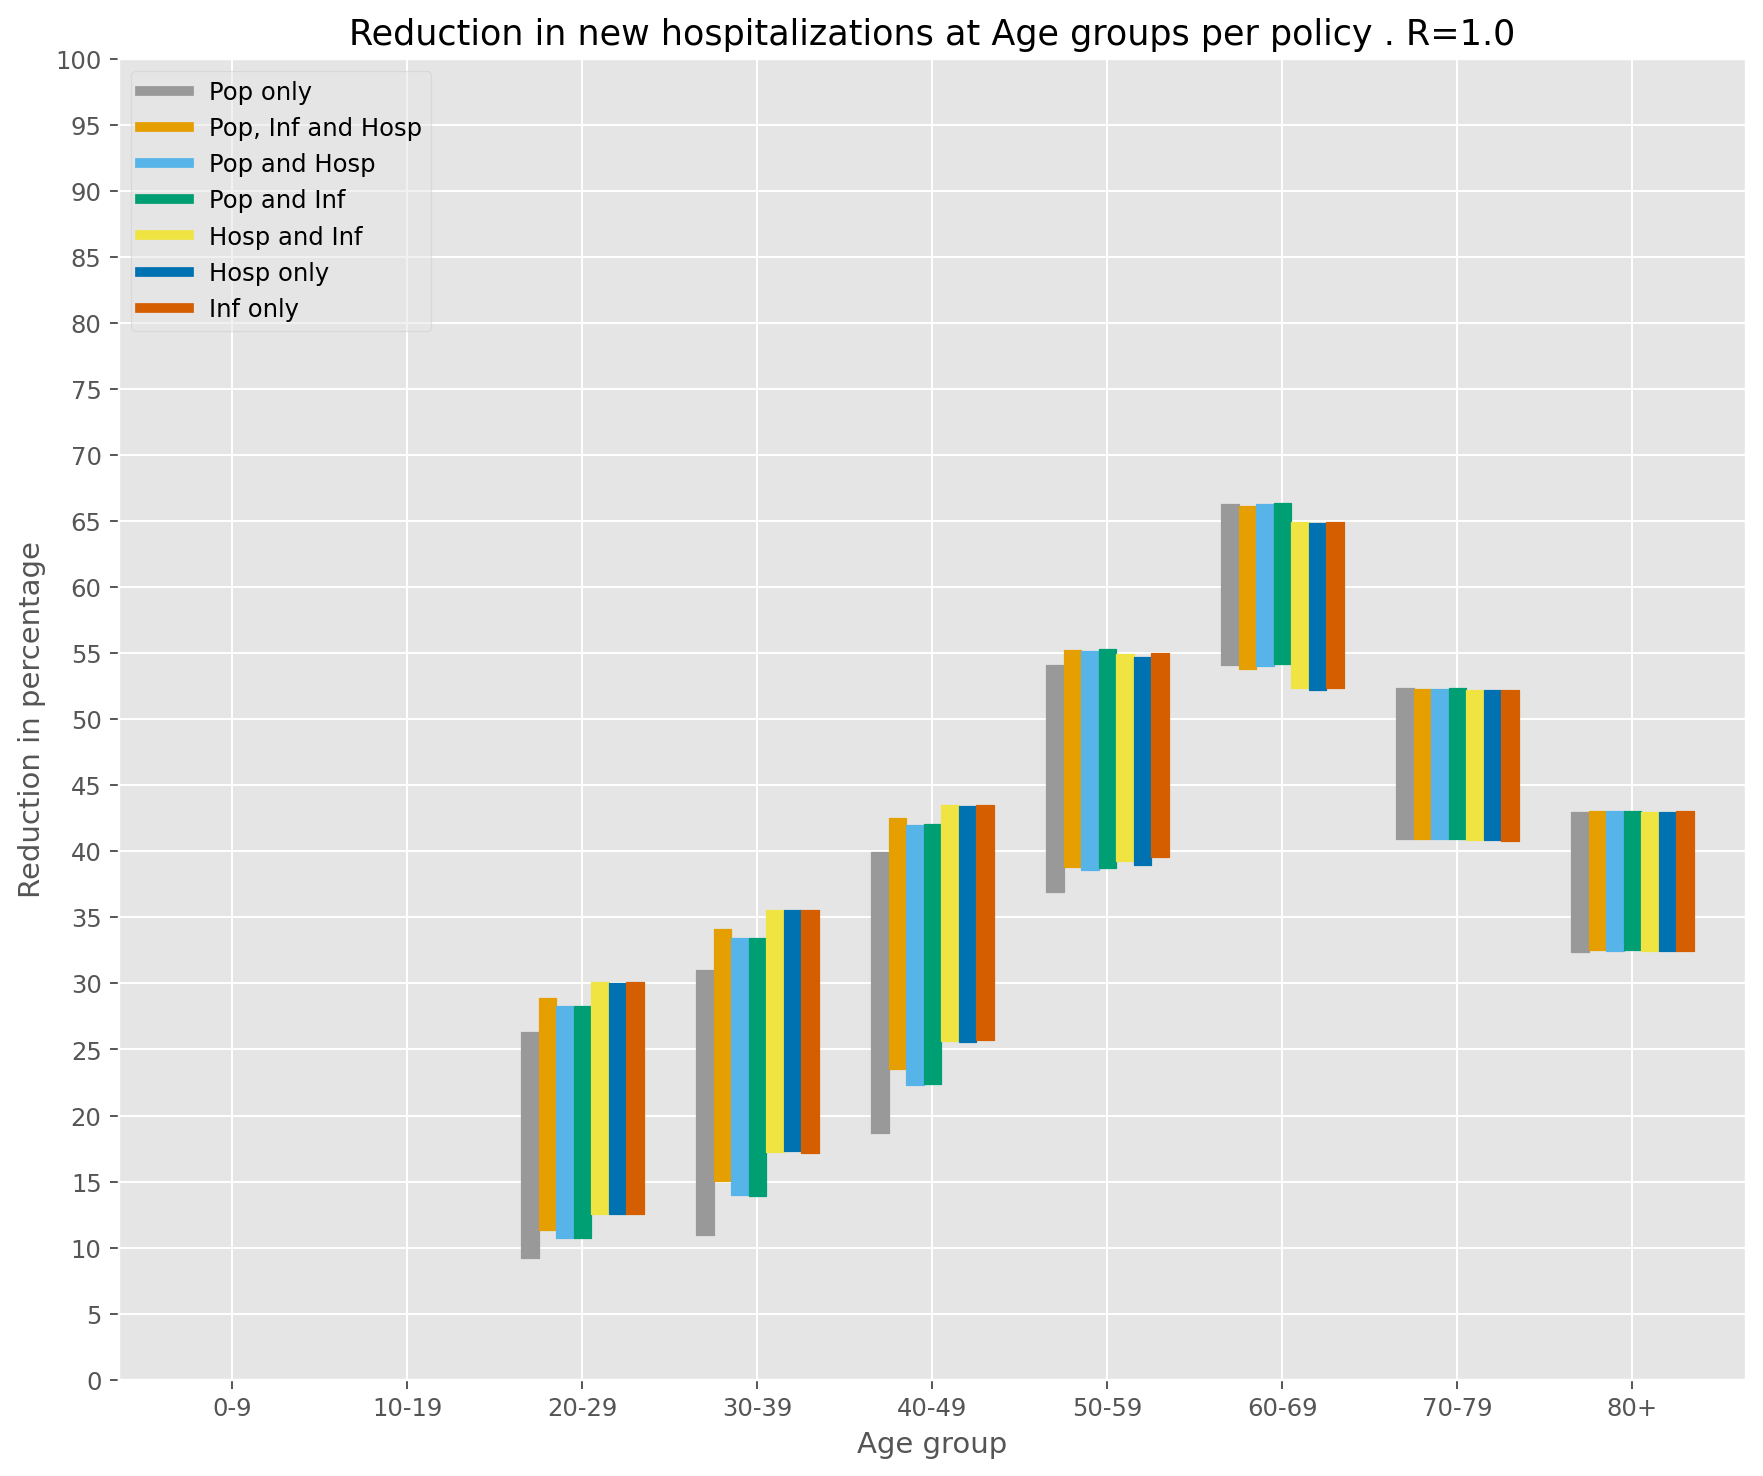

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[0], 'new hospitalizations', all_results, age_labels, 'Age group')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


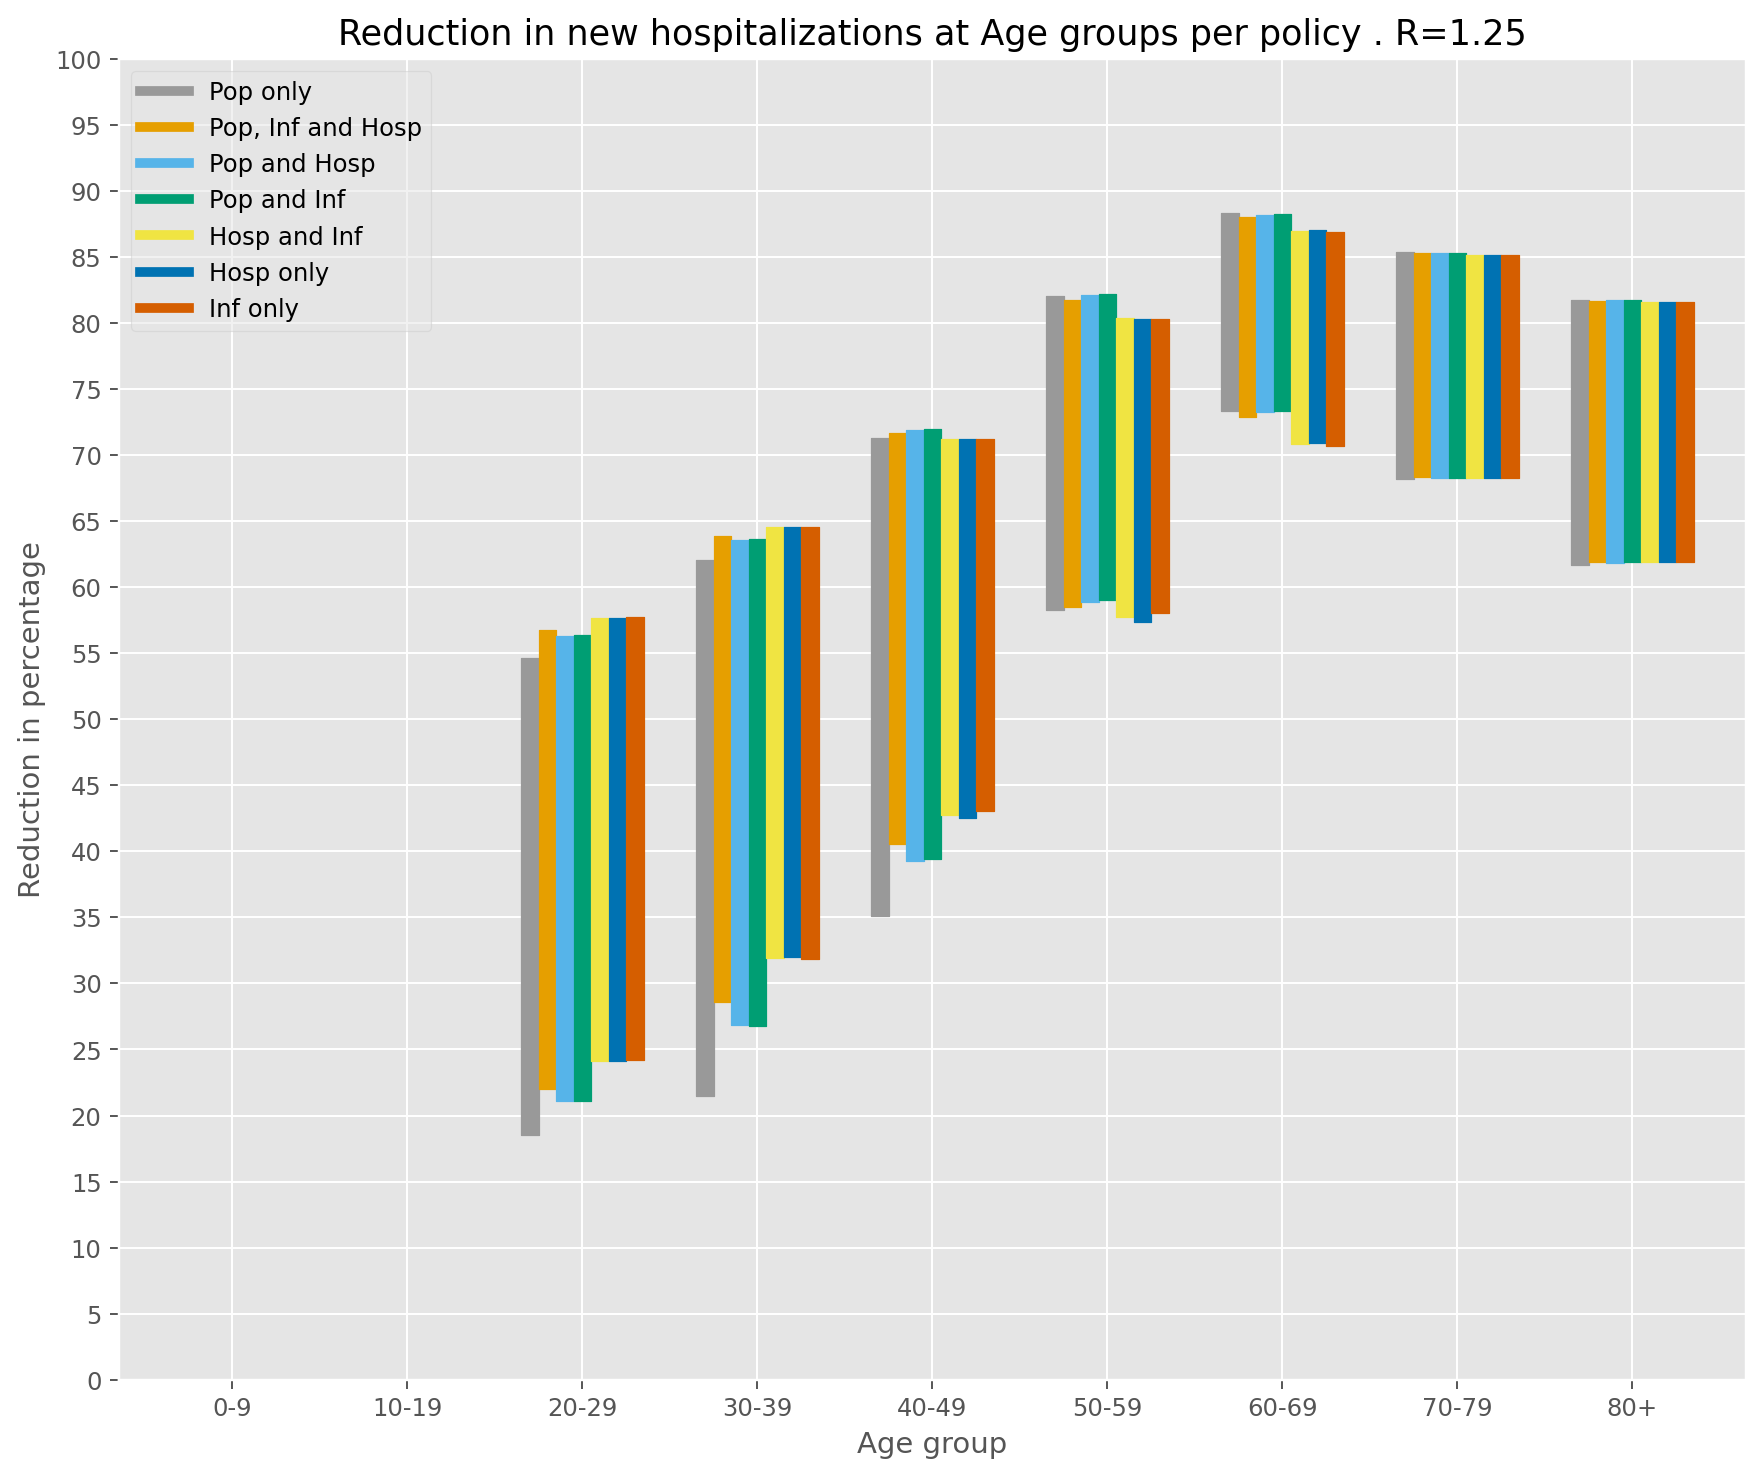

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[1], 'new hospitalizations', all_results, age_labels, 'Age group')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


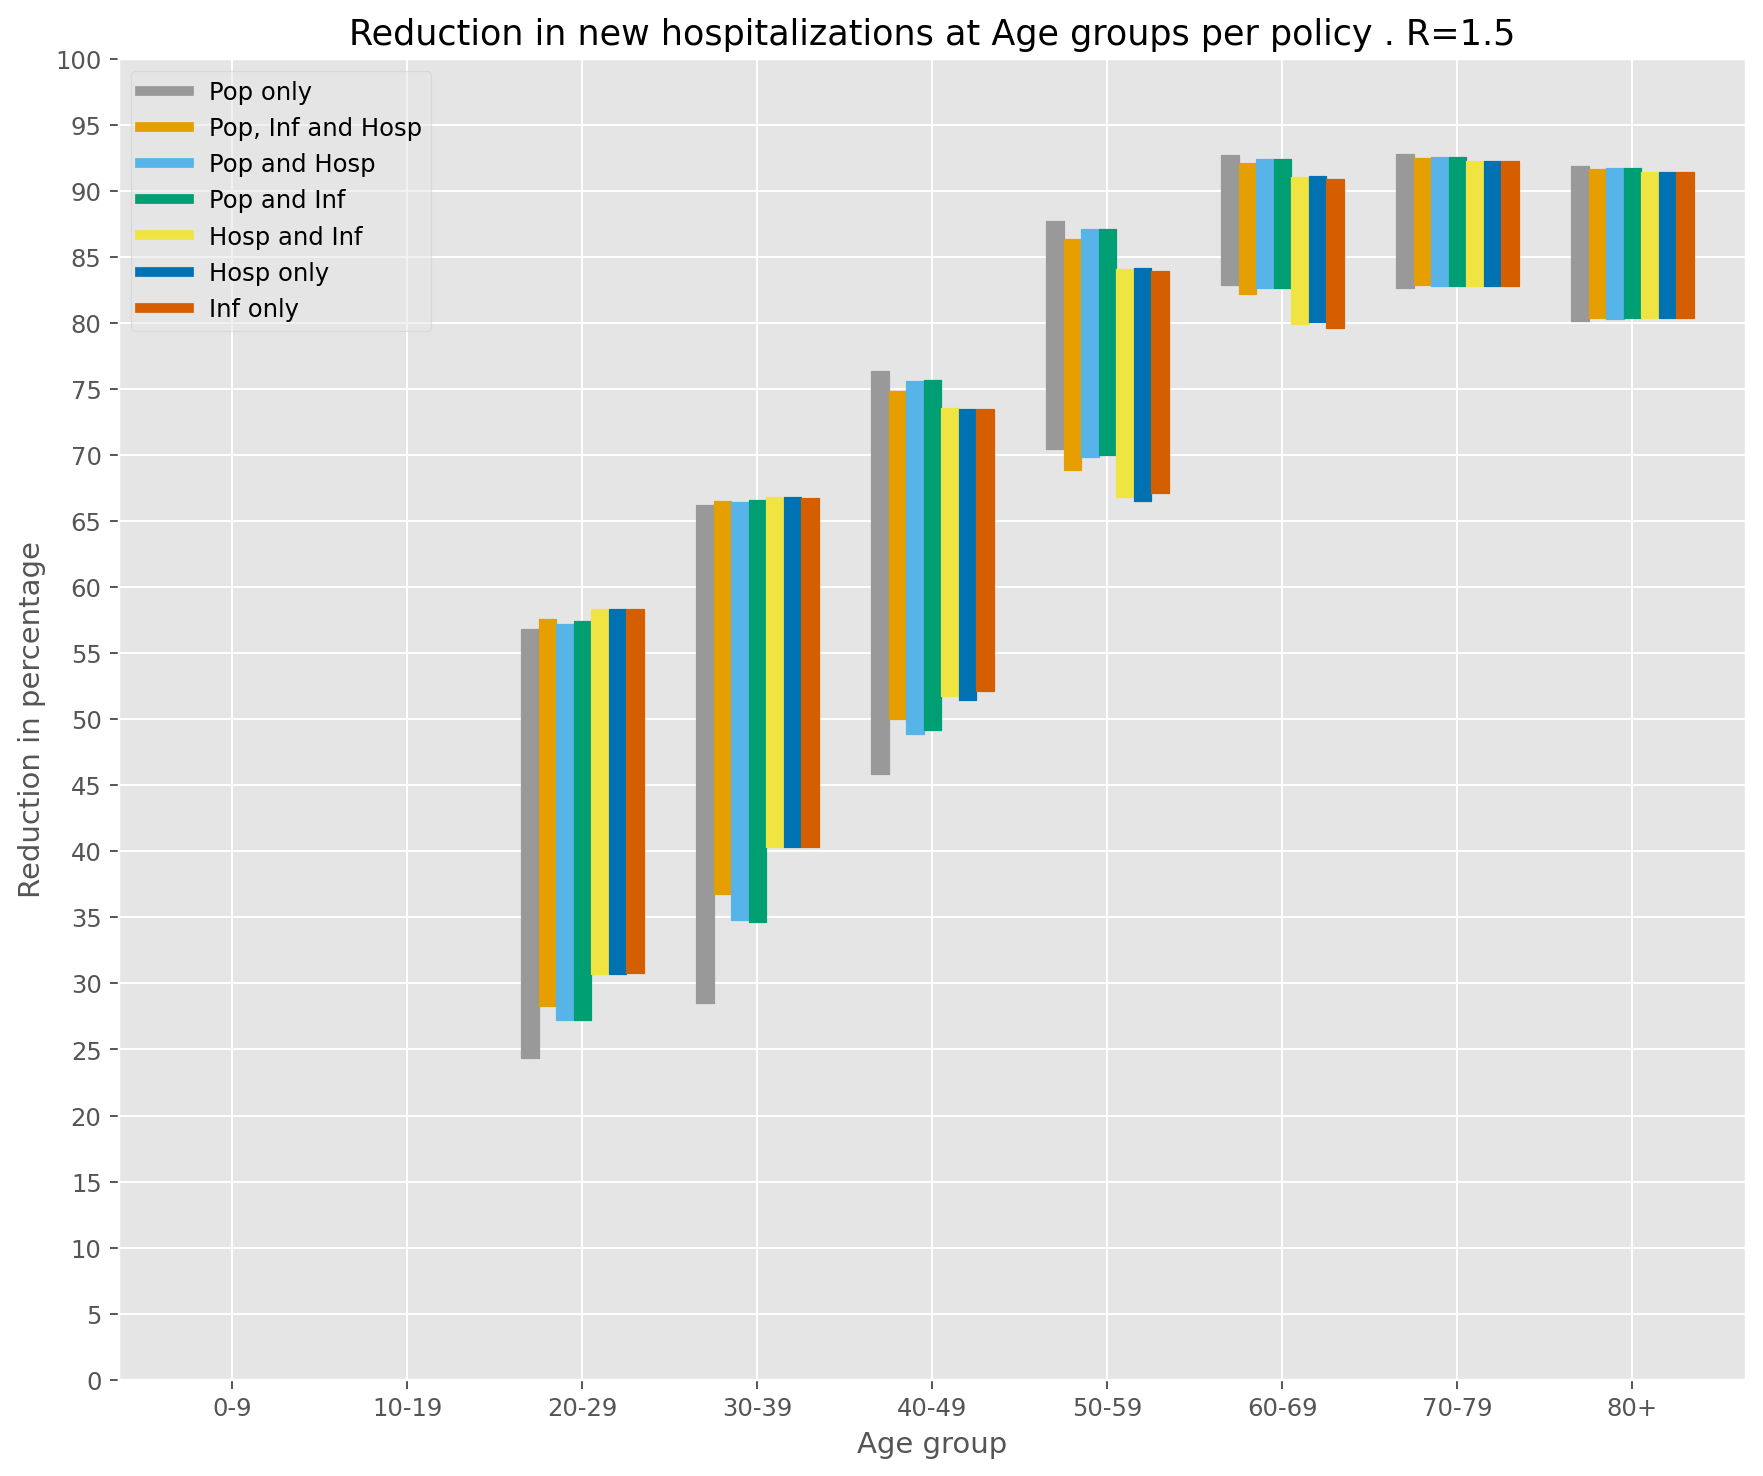

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[2], 'new hospitalizations', all_results, age_labels, 'Age group')

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


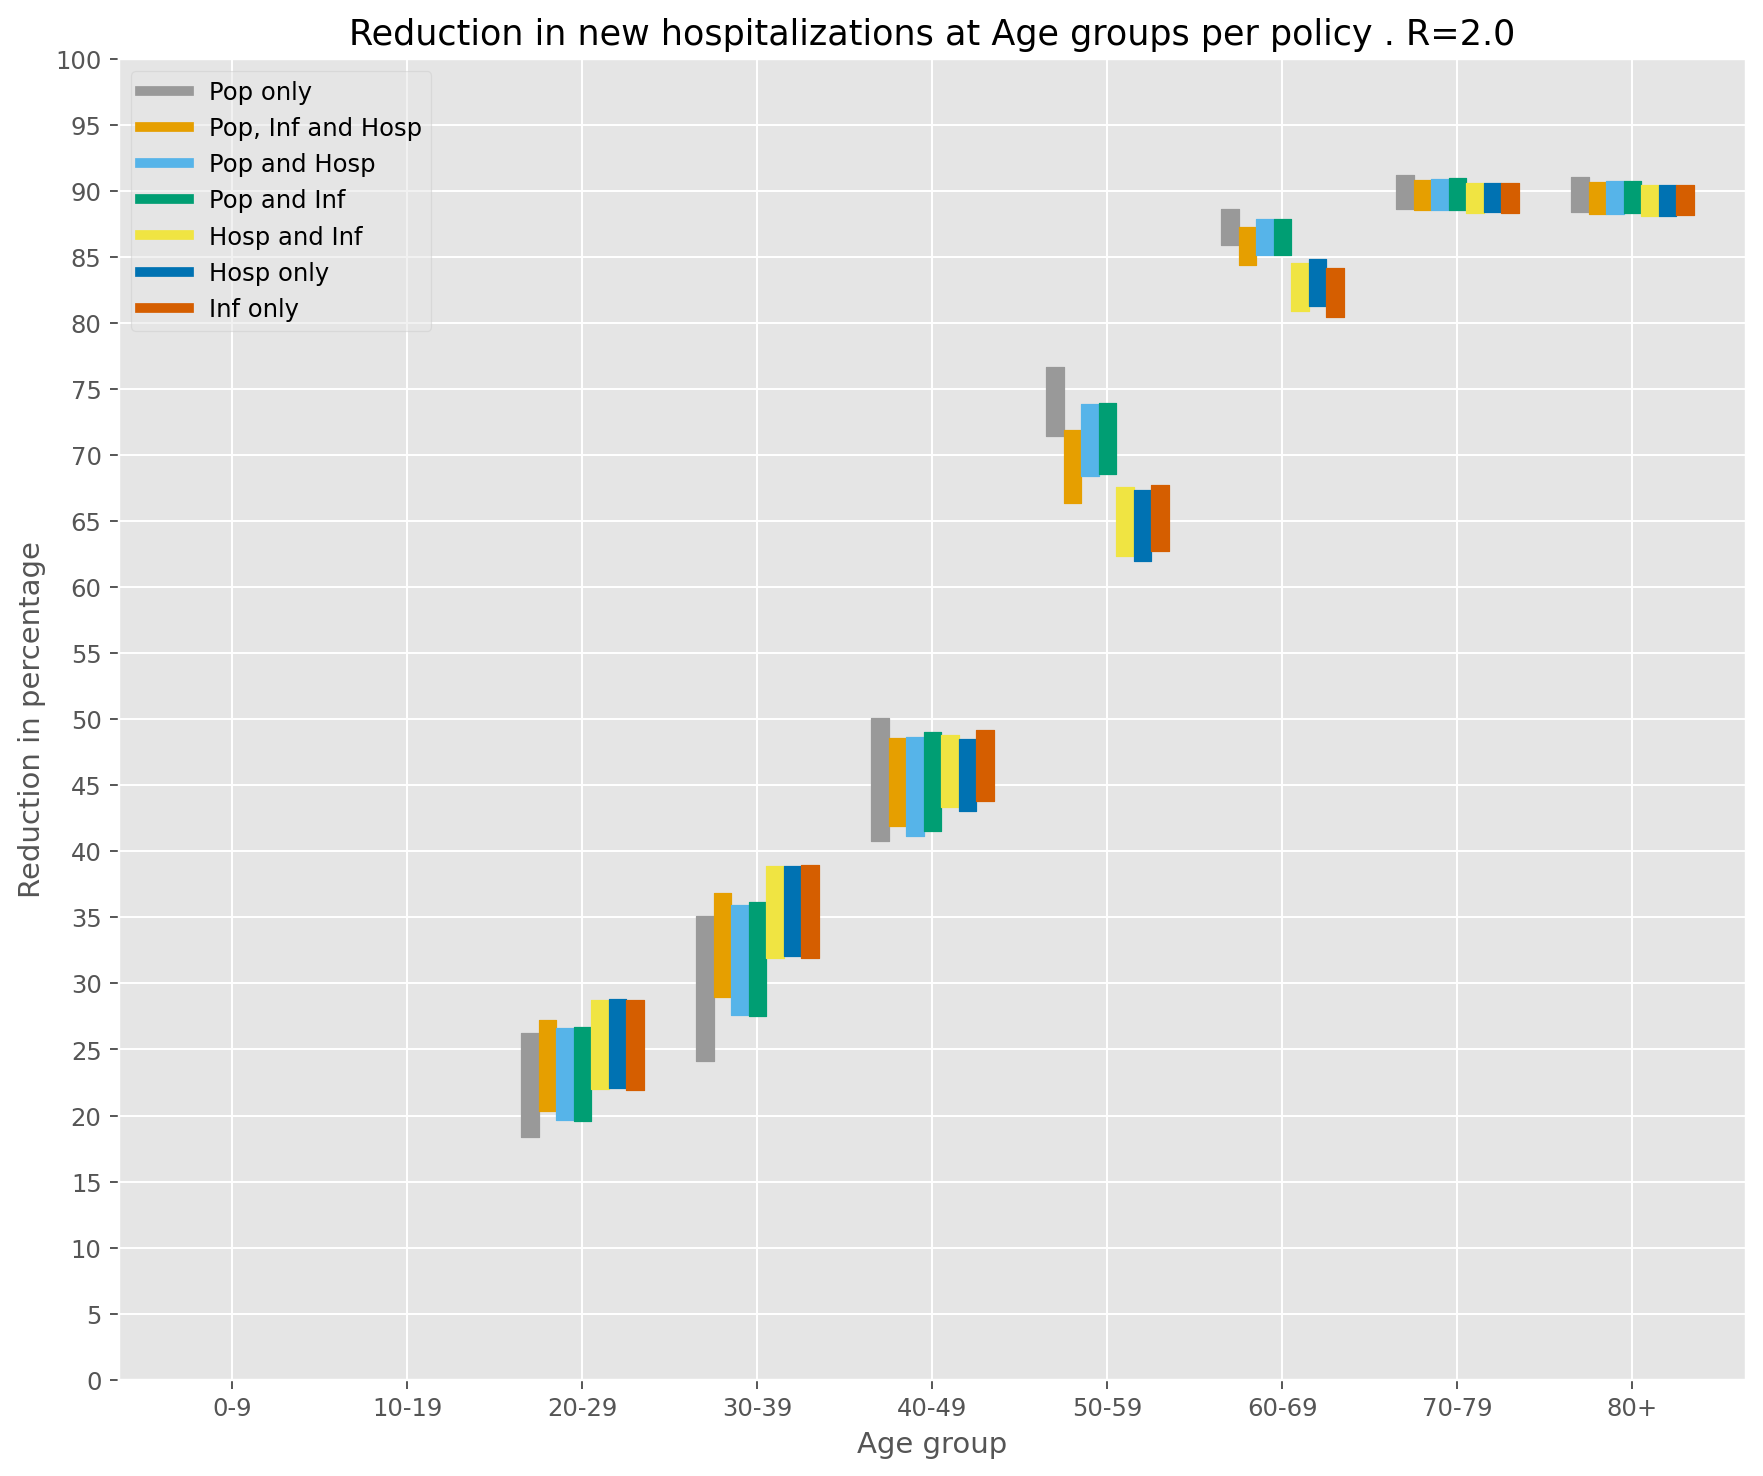

In [24]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[3], 'new hospitalizations', all_results, age_labels, 'Age group')

# Infections at age groups

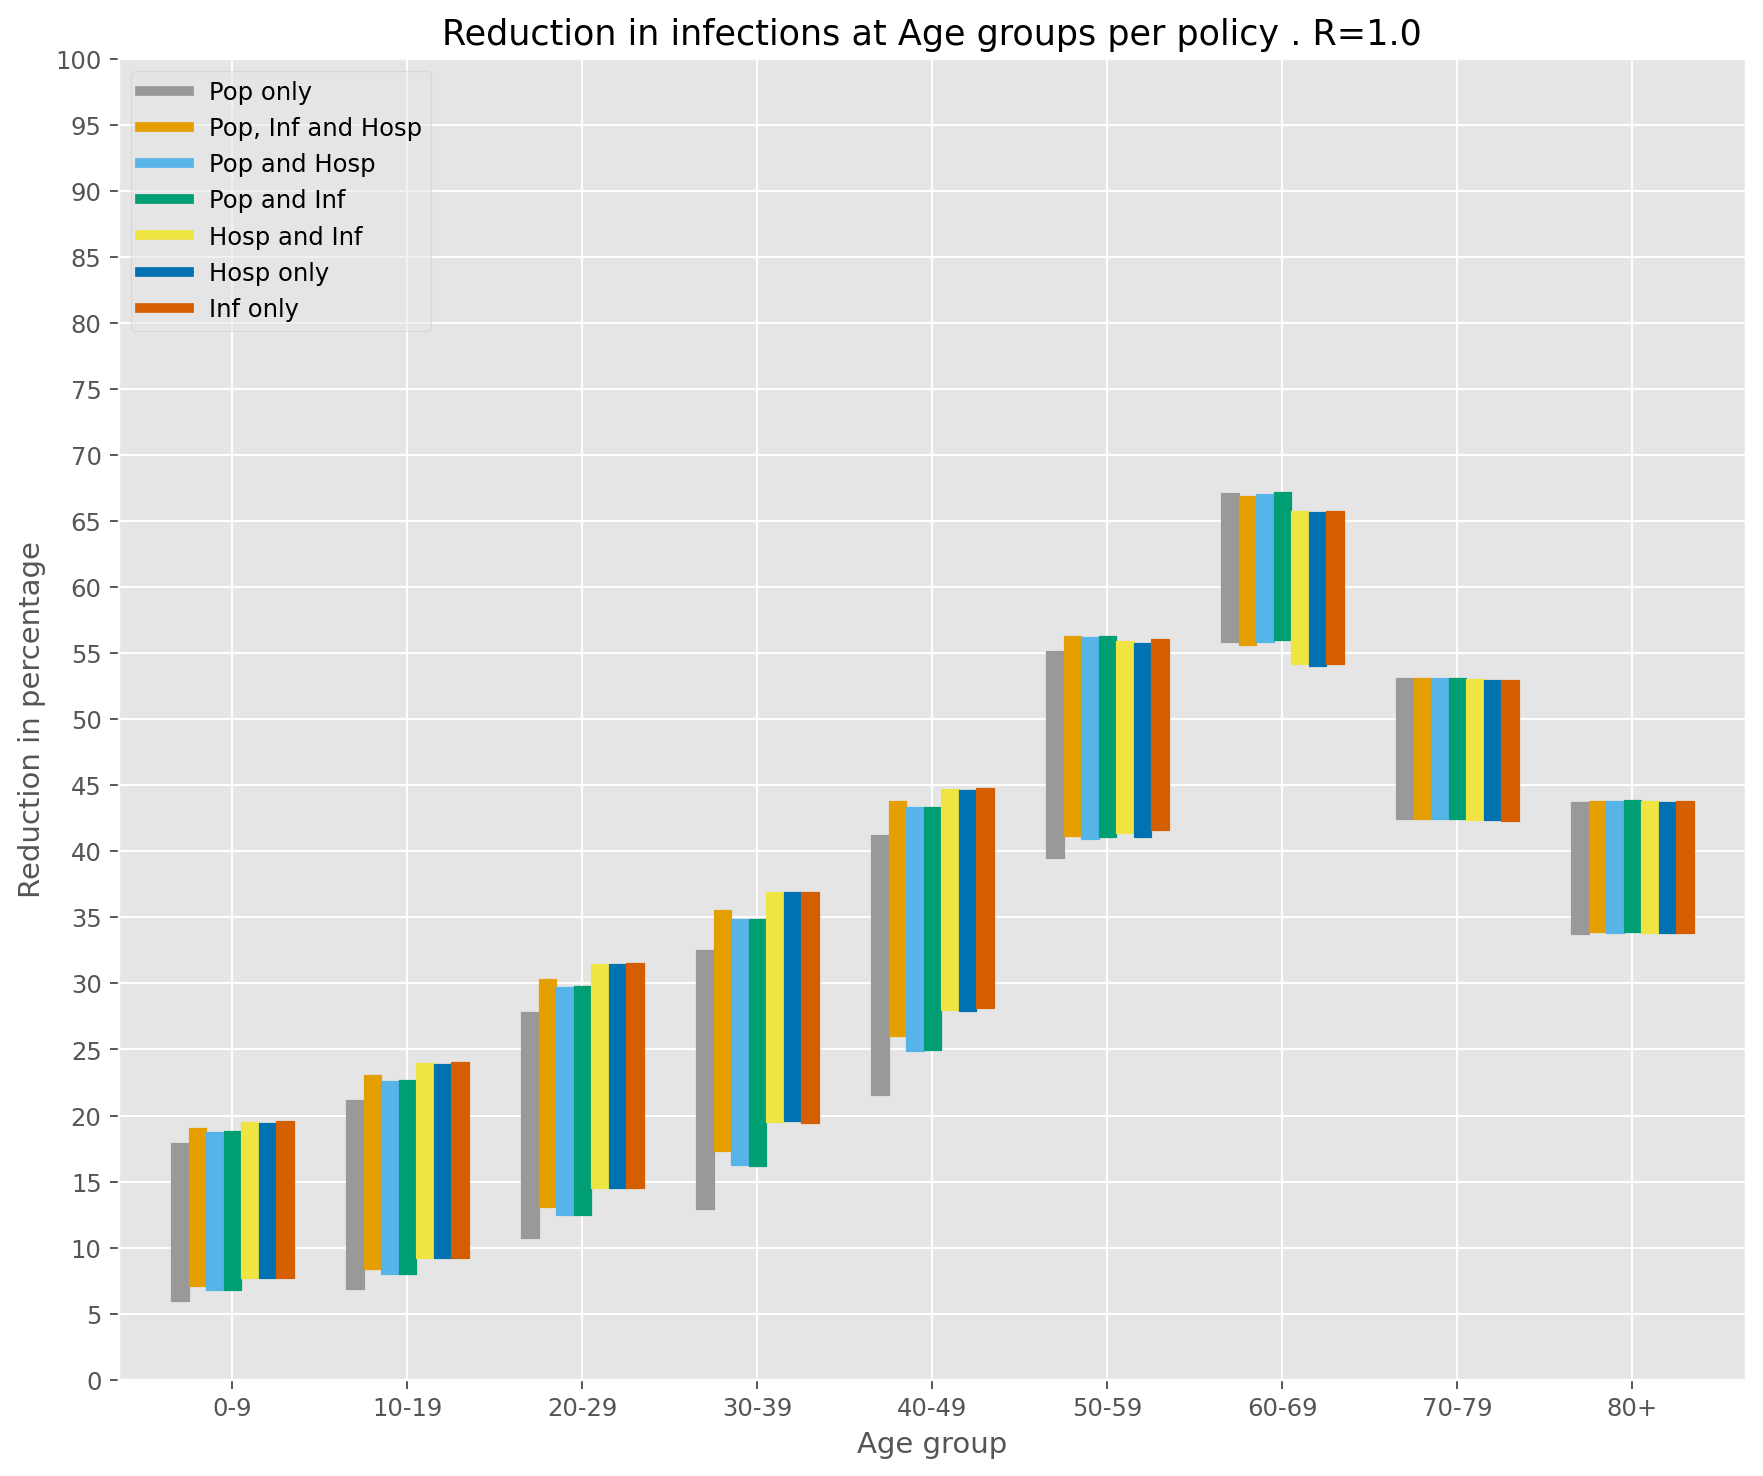

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[0], 'infections', all_results, age_labels, 'Age group')

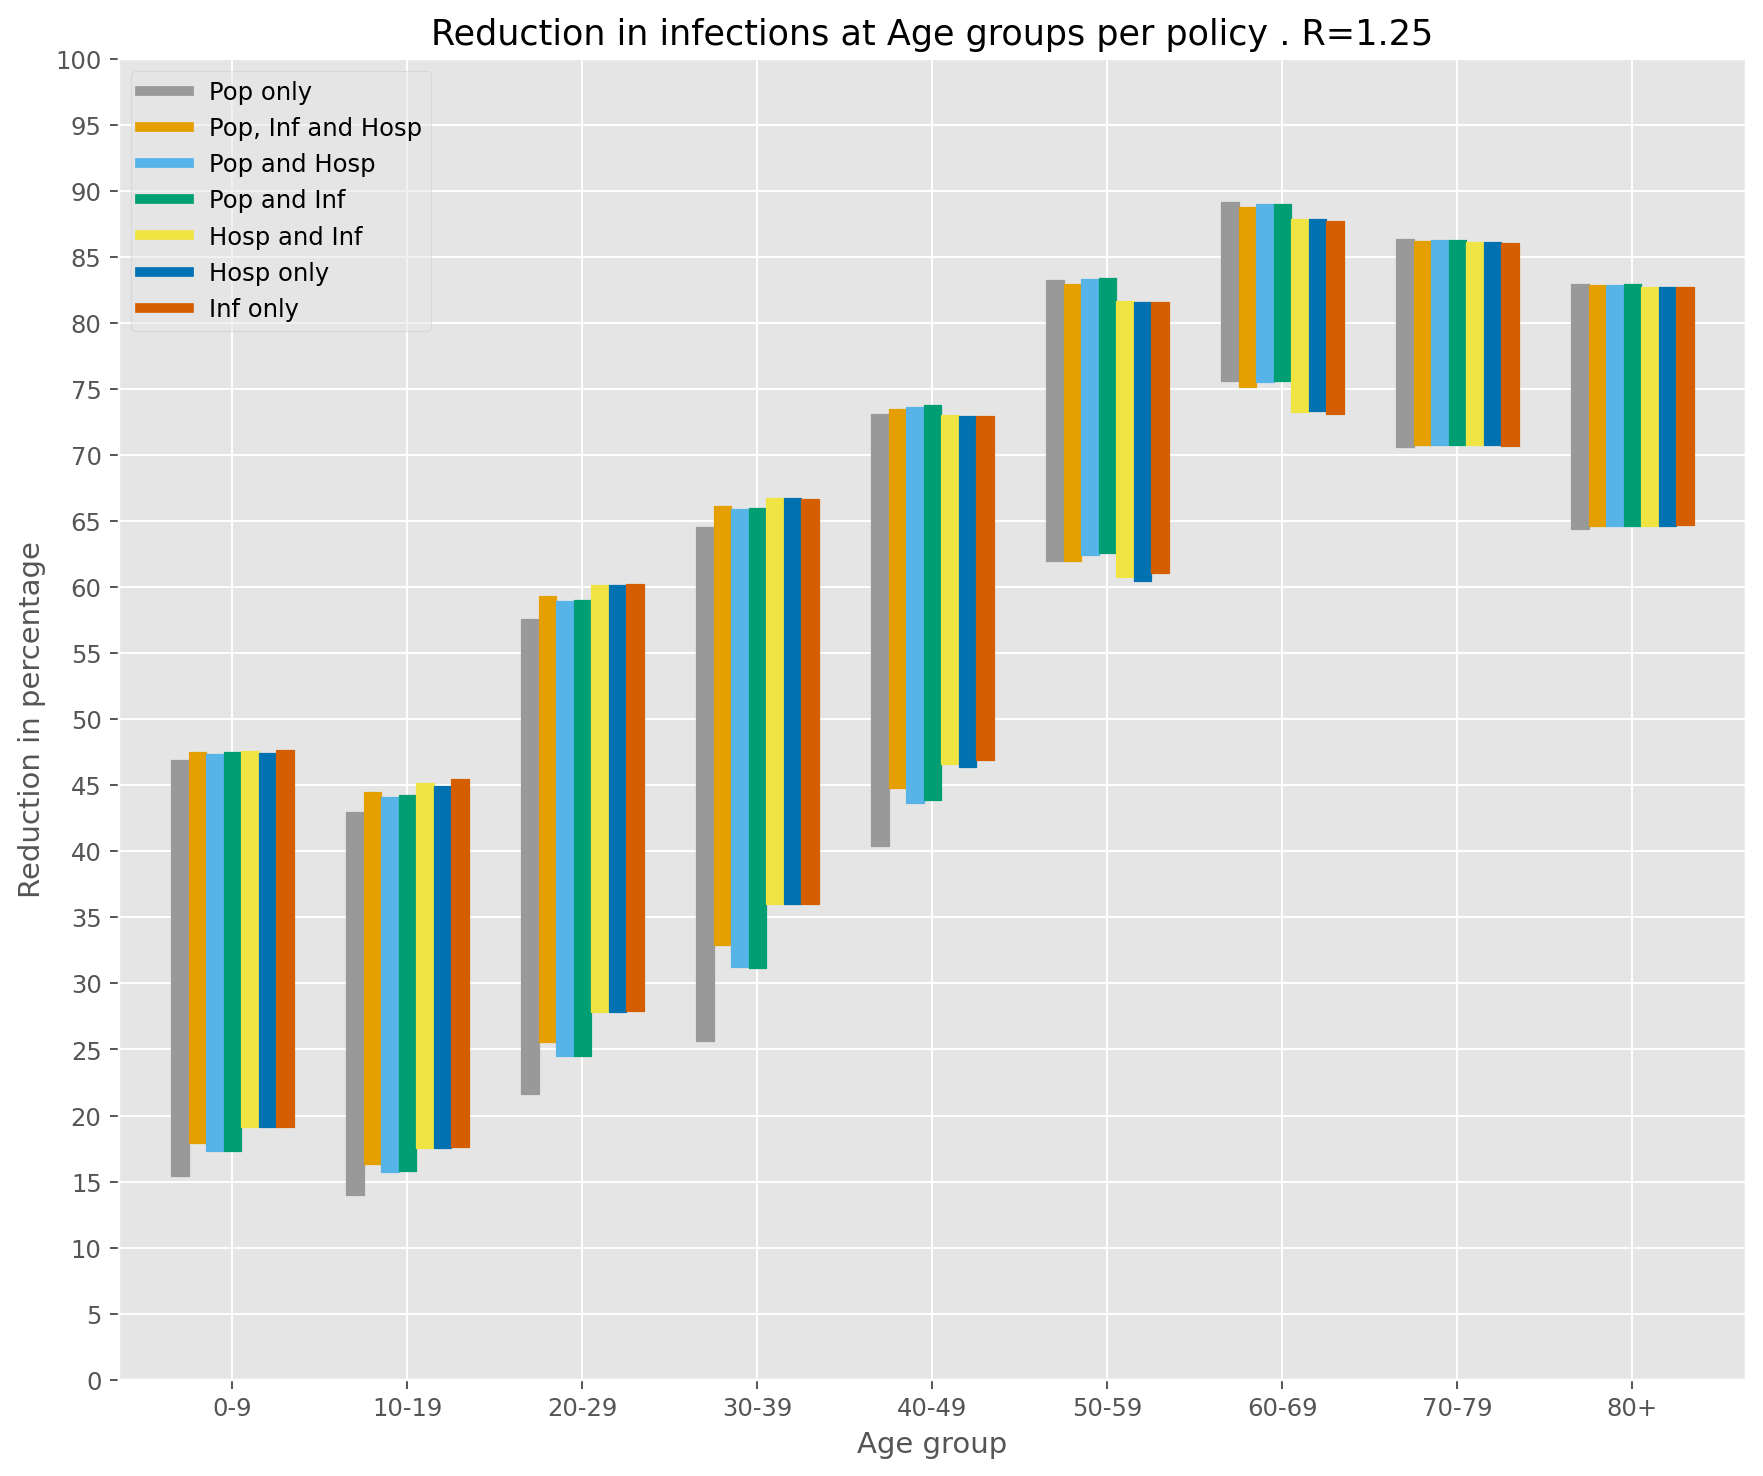

In [26]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[1], 'infections', all_results, age_labels, 'Age group')

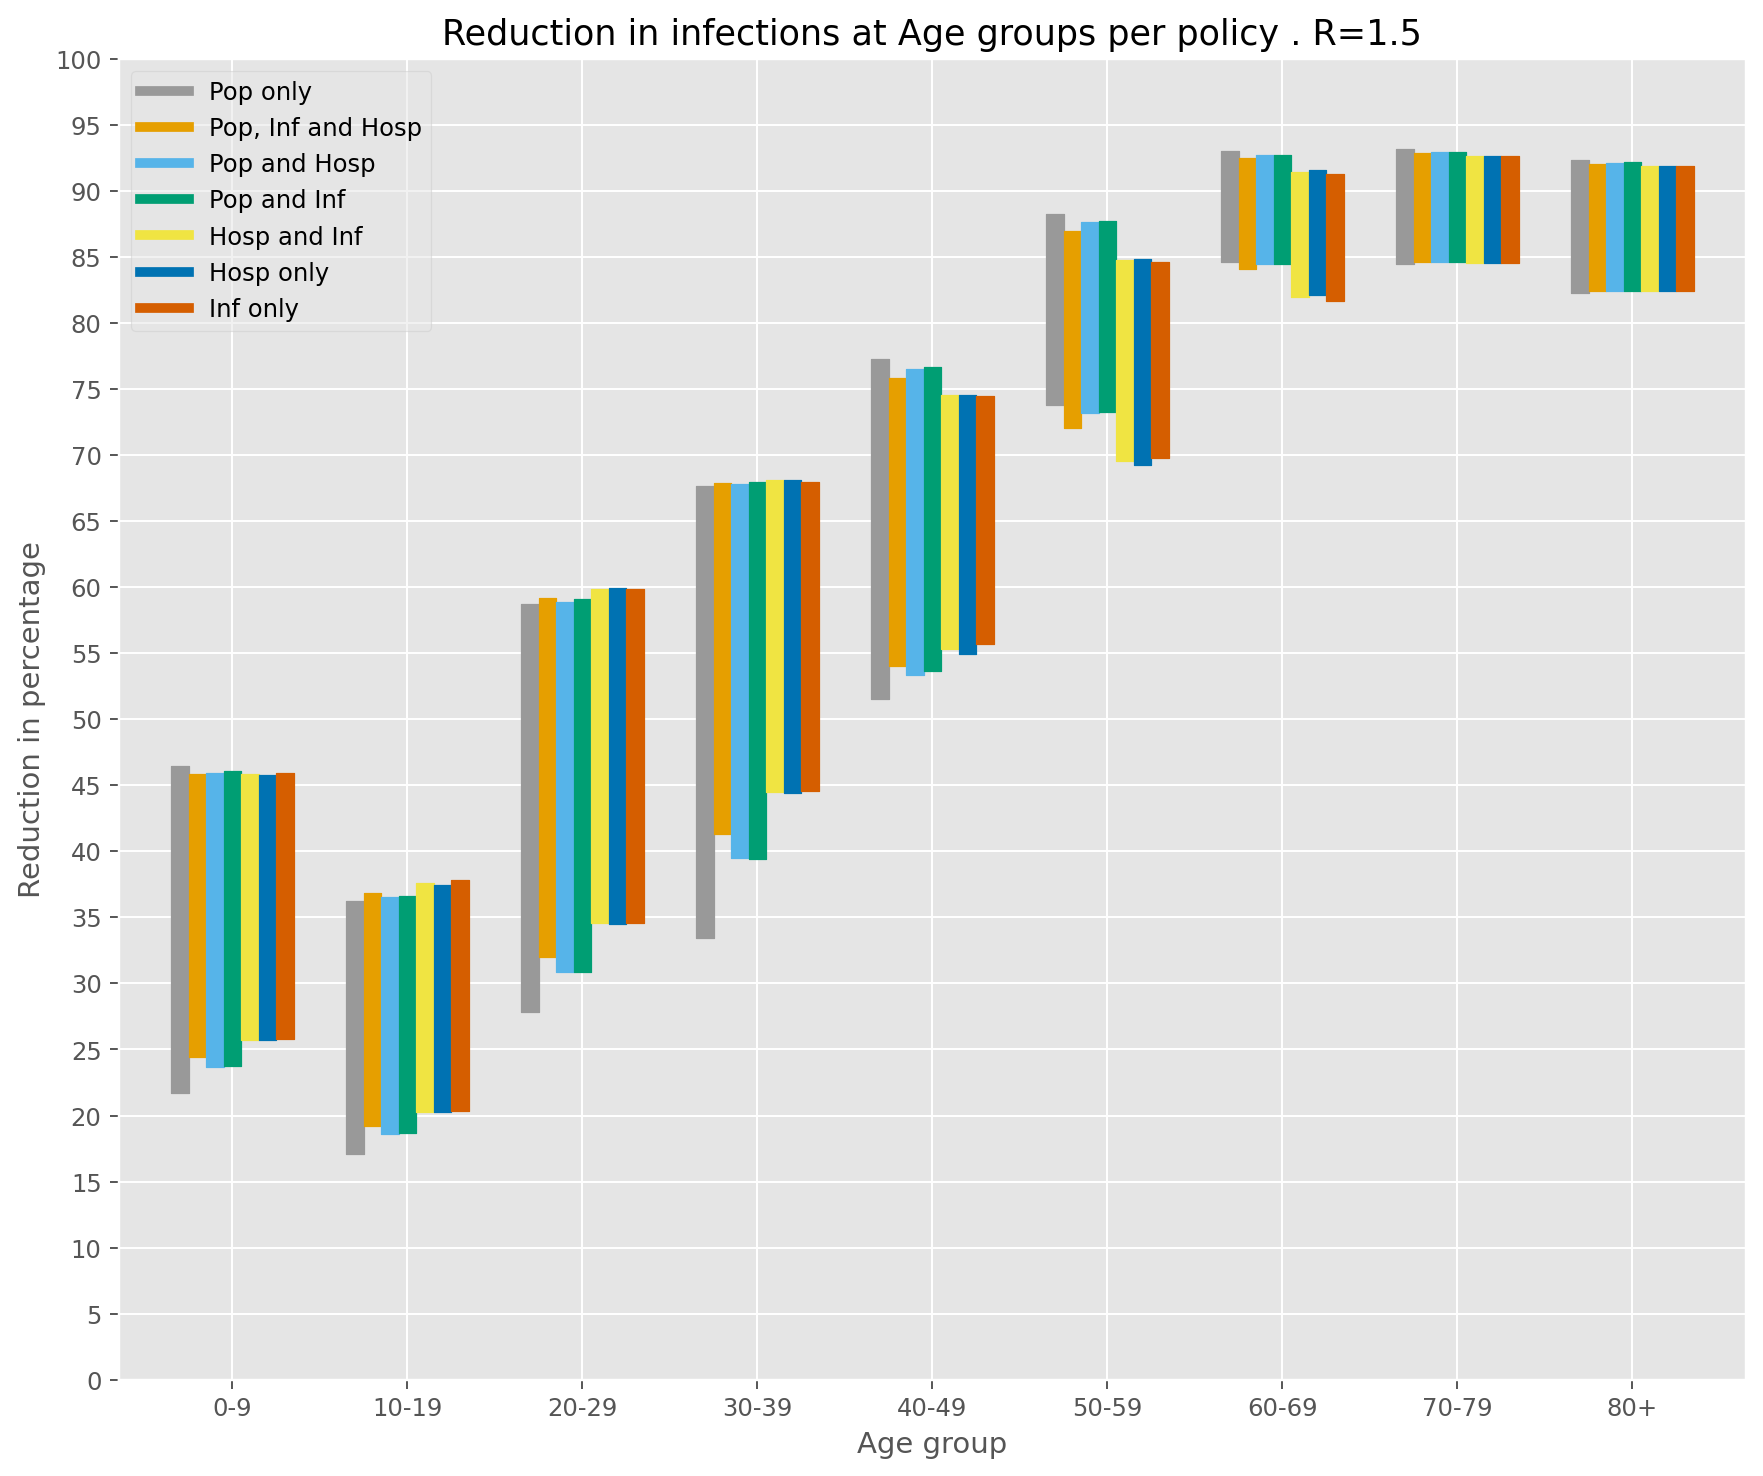

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[2], 'infections', all_results, age_labels, 'Age group')

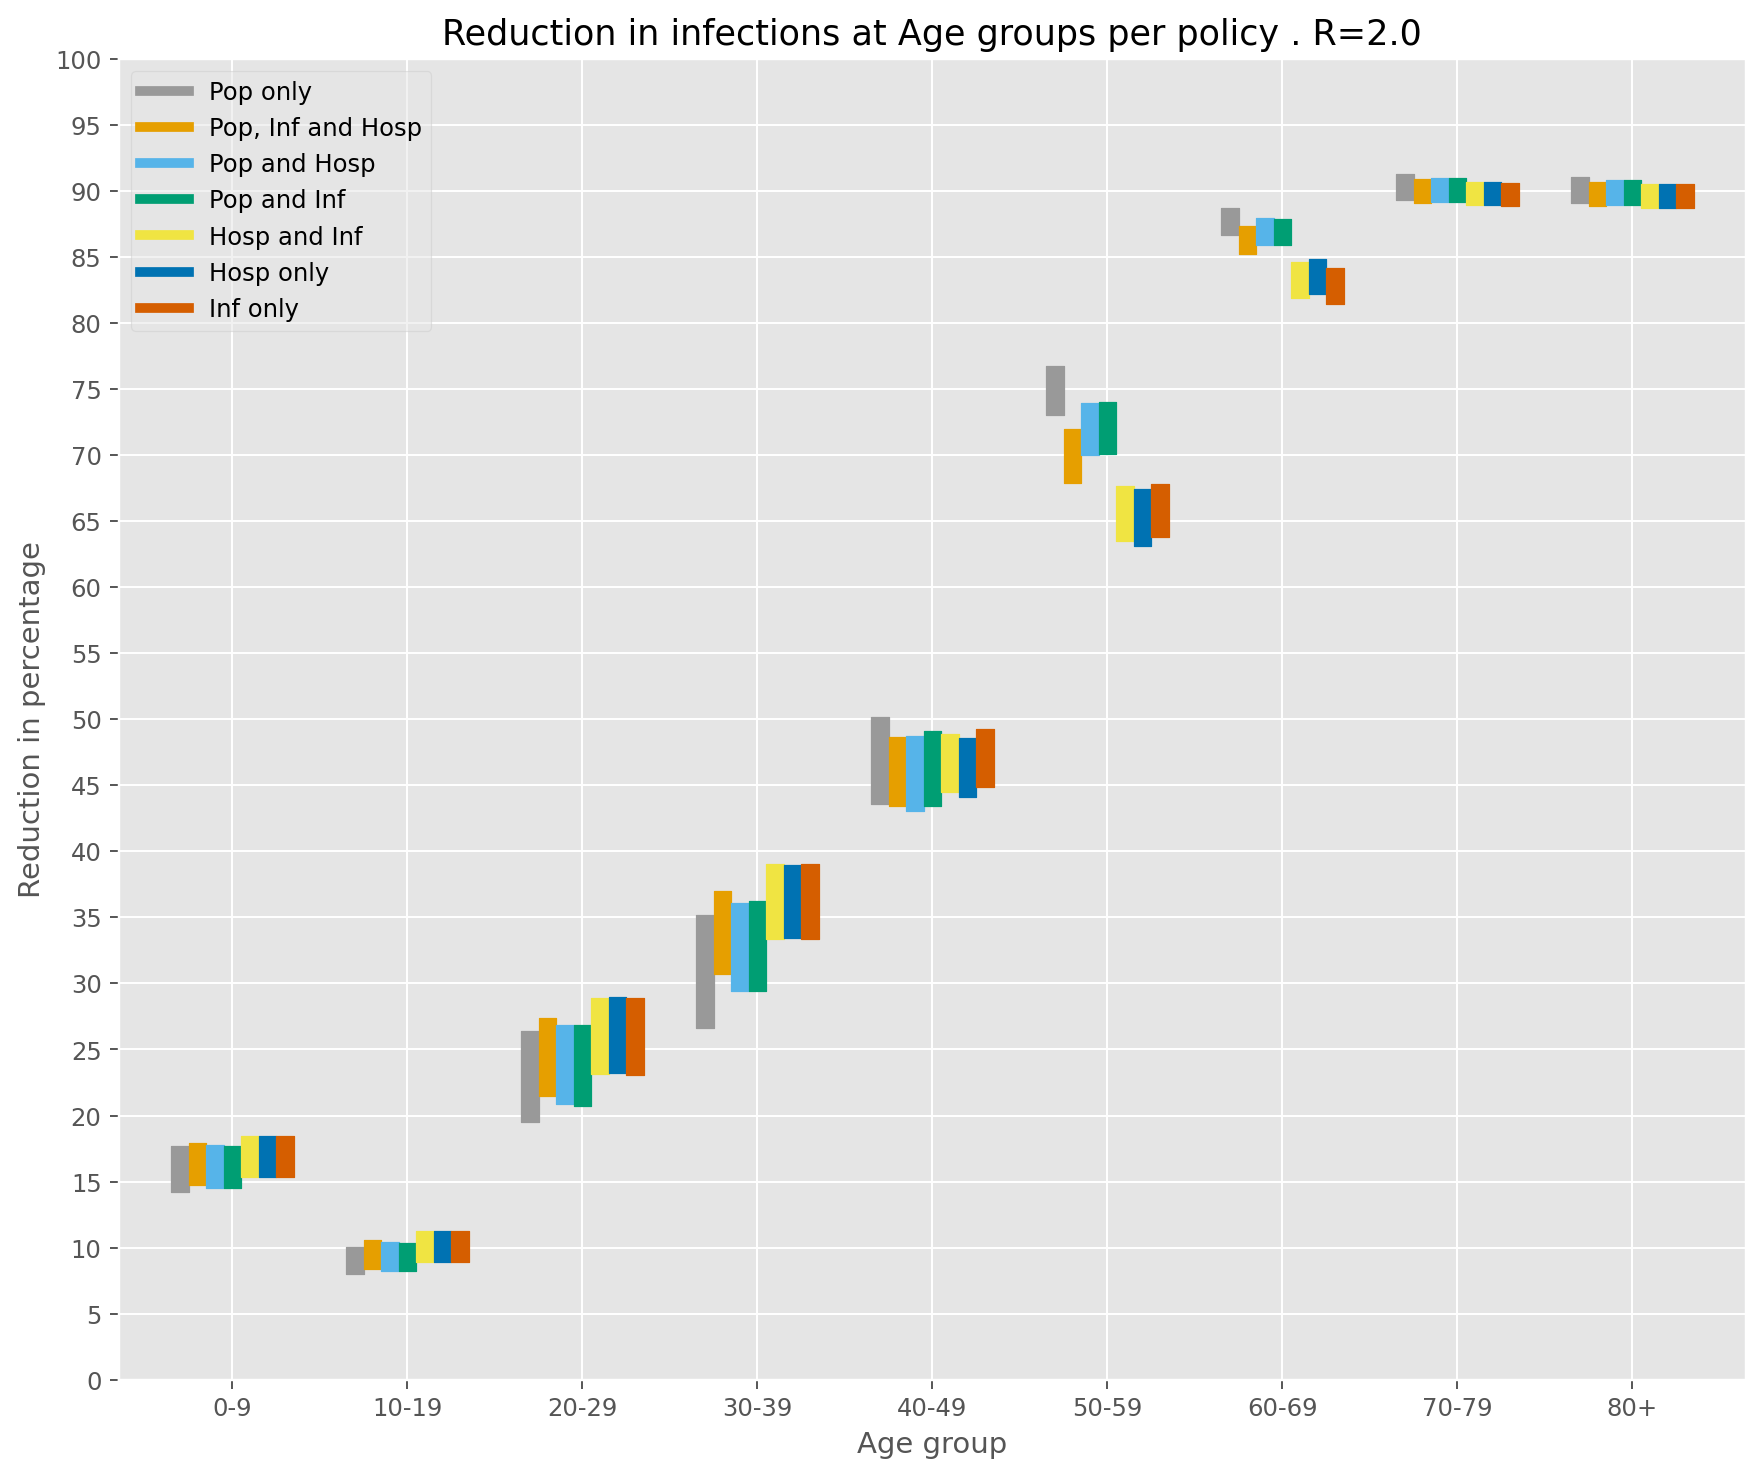

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r_experiments[3], 'infections', all_results, age_labels, 'Age group')